In [1]:
import json
import numpy as np
import glob
import os
import anndata

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pandas as pd
import json

import importlib

from dredFISH.Utils.__init__plots import *
from dredFISH.Utils import basicu 
from dredFISH.Utils.miscu import order_by_hc
from dredFISH.Utils import designu

# from dredFISH.Design.model_v2p2_gene_constraints import CellTypeNet
from dredFISH.Design import data_loader_scrna 

config = importlib.import_module("dredfish_processing_config")

importlib.reload(data_loader_scrna)
importlib.reload(designu)

<module 'dredFISH.Utils.designu' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Utils/designu.py'>

In [2]:
class InstNrm(nn.Module):
    """
    Performs normalization on projection with thresholding by value  
    
    Attributes
    ----------
        min_pos: minimum position  
        min_sgnl: minimum signal
        max_sgnl: maximum signal
        scale: scaling factors
        noise: range of noises for Poisson parameter
    """
    def __init__(self, min_pos= 1e5, min_sgnl=5e4, max_sgnl= 2.5e5, scale= 1.5e4, noise= (1e4, 1e3)):
        super().__init__()
        self.scale= torch.tensor(scale).log()
        self.noise= noise
        self.median= torch.tensor(min_pos) # median intensity -- as each cell has half +; it is the "minimum pos" as well 
        self.min_sgnl= torch.tensor(min_sgnl)
        self.max_sgnl= torch.tensor(max_sgnl)

    def forward(self, X):
        """
        Forward propagation with Poisson noise added
        
        Attributes
        ----------
        X: (projected) gene count matrix
        
        Returns
        -------
        (X1-l)/self.scale: standardized input
        lower + upper + median: quartile error 
        """
        
        # Poisson noise
        if self.noise is None:
            X1= X.log()
        else:
            X1= (X + torch.poisson(self.noise[0]*torch.ones_like(X) + self.noise[1]*torch.randn_like(X))).log()
        # each coarse level cell type will have a median expression value, which is the difference between the last low value
        # and the first high value 
        o= X1.sort(1)[0] # sort by bits (by col). [0] - val; [1] - indices
        a= o[:,:o.shape[1]//2] # smaller half
        b= o[:,o.shape[1]//2:] # bigger half
        l= (a[:,-1:] + b[:,:1])/2 # middle values for each cell
        
        # lower and upper are bounds on expression, we want counts within their threshold
        lower= ((self.min_sgnl - X).clamp(0)**2).mean() # X lower than min
        upper= ((X - self.max_sgnl).clamp(0)**2).mean() # X larger than max
        median= ((self.median - b.exp()).clamp(0)**2).mean() # larger half lower than median  
        return (X1-l)/self.scale, lower + upper + median

In [3]:
def normalize_w_v2(W, cnstrnts, num_tp=90000):
    """Normalize the matrix W from DPNMF
    - scale 
    - integerize
    - cap probe constraints
    - remove genes with no weights
    
    arguments:
    - W: DataFrame
    """
    assert len(W) == len(cnstrnts)
    
    # scale
    Wn = W/(W.sum().sum())*num_tp
    # integerize 
    Wn = (Wn+0.5).astype(int)
    # # constraints
    # for col in Wn:
    #     Wn[col] = np.clip(Wn[col], None, cnstrnts)
        
    # constraints (total counts of a gene across 24 basis has limit)
    cnstrnts_scale = np.clip(Wn.sum(axis=1)/cnstrnts, 1, None).values # at least 1; maybe >1 
    Wn = Wn/cnstrnts_scale.reshape(-1,1)
    Wn = Wn.fillna(0).astype(int) # NaN means cnstrnts == 0
        
    # remove genes with no weights
    nonzero_cond = Wn.sum(axis=1)>0  
    
    Wn_slim = Wn.loc[nonzero_cond]
    
    print(f"Total num probes: {Wn.sum().sum():,}")
    print(f"Total num genes: {nonzero_cond.sum():,}")
    return Wn, Wn_slim, nonzero_cond

In [4]:
def proc_pmat(pmat, ftrs_all, genes_idx, clsts, _drows=None):
    """
    """
    prx = torch.from_numpy(pmat.values).float()
    
    ftrs = basicu.libsize_norm(ftrs_all, scale=1e6)
    ftrs = ftrs[:,genes_idx] 
    prjx = ftrs.mm(prx)
    # if option == 'dpnmf':
    embx = prjx #/torch.reshape(prjx.sum(1), (-1,1)) #+1
    # else:
    #     embx = np.log10(prjx+1)
        
    # elif option == 'igor':
    #     embx, _reg = nrmNN.forward(prjx)

    prjx = prjx.numpy()
    embx = embx.numpy()
    print(prjx.shape, embx.shape, clsts.shape)

    nzero_prbe_cond = pmat.sum(axis=1) > 0
    pospmat = pmat[nzero_prbe_cond]
    fpmat = pospmat.divide(pospmat.sum(axis=0), axis=1)
    print(pospmat.shape, fpmat.shape)

    prjx_clsts, _ = basicu.group_mean(prjx, clsts)
    embx_clsts, _ = basicu.group_mean(embx, clsts)
    embx_clsts_z  = basicu.zscore(embx_clsts, allow_nan=True, axis=0)
    embx_clsts_corr = np.corrcoef(embx_clsts_z)

    # order by HC
    _rows = order_by_hc(embx_clsts)
    _cols = order_by_hc(embx_clsts.T)
    
    # order to emphasize diagonal elements (columns) (take quite long)
    _, _, _dcols = basicu.diag_matrix_cols(embx_clsts_z[_drows,:]) # this takes quite long
    
    return fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols

In [5]:
loadings = np.load('/bigstore/binfo/mouse/Brain/DRedFISH/Archive/24bit_DRedFISH_Loadings.npy')
norm_loadings = loadings#/loadings.sum(1)[:,None] # Normalize By Bit
norm_loadings = norm_loadings/norm_loadings.sum()
norm_loadings = 90000*norm_loadings
norm_loadings = norm_loadings.astype(int)
norm_loadings.max(),norm_loadings.sum()

(514, 86572)

In [6]:
device = torch.device('cpu')
torch.manual_seed(0) # reproduciability

In [7]:
for i, bit in enumerate(config.bitmap):
    print(i, bit)

0 ('RS0109_cy5', 'hybe2', 'FarRed')
1 ('RS0175_cy5', 'hybe3', 'FarRed')
2 ('RS0237_cy5', 'hybe4', 'FarRed')
3 ('RS0307_cy5', 'hybe5', 'FarRed')
4 ('RS0332_cy5', 'hybe6', 'FarRed')
5 ('RS0384_atto565', 'hybe10', 'FarRed')
6 ('RS0406_atto565', 'hybe11', 'FarRed')
7 ('RS0451_atto565', 'hybe12', 'FarRed')
8 ('RS0468_atto565', 'hybe13', 'FarRed')
9 ('RS0548_atto565', 'hybe14', 'FarRed')
10 ('RS64.0_atto565', 'hybe15', 'FarRed')
11 ('RS156.0_alexa488', 'hybe19', 'FarRed')
12 ('RS278.0_alexa488', 'hybe20', 'FarRed')
13 ('RS313.0_alexa488', 'hybe21', 'FarRed')
14 ('RS643.0_alexa488', 'hybe22', 'FarRed')
15 ('RS740.0_alexa488', 'hybe23', 'FarRed')
16 ('RS810.0_alexa488', 'hybe24', 'FarRed')
17 ('RSN9927.0_cy5', 'hybe7', 'FarRed')
18 ('RSN2336.0_cy5', 'hybe8', 'FarRed')
19 ('RSN1807.0_cy5', 'hybe9', 'FarRed')
20 ('RSN4287.0_atto565', 'hybe16', 'FarRed')
21 ('RSN1252.0_atto565', 'hybe17', 'FarRed')
22 ('RSN9535.0_atto565', 'hybe18', 'FarRed')
23 ('RS0095_cy5', 'hybe1', 'FarRed')
24 ('PolyT', 'hyb

In [8]:
pmat_cols = [bit[0].split('_')[0] for bit in config.bitmap[:24]]
pmat_cols

['RS0109',
 'RS0175',
 'RS0237',
 'RS0307',
 'RS0332',
 'RS0384',
 'RS0406',
 'RS0451',
 'RS0468',
 'RS0548',
 'RS64.0',
 'RS156.0',
 'RS278.0',
 'RS313.0',
 'RS643.0',
 'RS740.0',
 'RS810.0',
 'RSN9927.0',
 'RSN2336.0',
 'RSN1807.0',
 'RSN4287.0',
 'RSN1252.0',
 'RSN9535.0',
 'RS0095']

In [9]:
# the dataset
trn_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_trn', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=64,
)
tst_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_tst', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=5000,
)
f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna', 'gidx_cnstrnts_pshop_mm10_isoflat.pt')
cnstrnts_idx = torch.load(f)
f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna',      'cnstrnts_pshop_mm10_isoflat.pt')
cnstrnts = torch.load(f)

n_gns = len(cnstrnts) # trn_dataloader.dataset.X.shape[1] # number of genes
n_cat = len(trn_dataloader.dataset.Ycat) # number of clusters
genes_data = tst_dataloader.dataset.data['genes'][:] #.Genes
genes_cnst = genes_data[cnstrnts_idx]
print(genes_data.shape, genes_cnst.shape)

(45768,) (23282,)


In [10]:
%%time
# validation dataset
ftrs_all, clsts = next(iter(tst_dataloader))
ftrs_all = ftrs_all.float()#.numpy() # all features
clsts = clsts.long().numpy()

CPU times: user 1min 25s, sys: 13.3 s, total: 1min 38s
Wall time: 14.5 s


In [11]:
# cluster annotation
clst_annots = tst_dataloader.dataset.Ycat[:]
type_orders = clst_annots[np.unique(clsts)]

# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'
with open(meta_path, 'r') as fh:
    meta = json.load(fh)
l3clst_order = np.array(meta['l3_clsts']) # get cluster order

_rows_l3clsts = basicu.get_index_from_array(type_orders, l3clst_order)

l3clst_order.shape, type_orders.shape, _rows_l3clsts

((42,),
 (42,),
 array([34, 38, 39, 41, 37, 28, 29, 11, 17, 18, 24,  6, 10,  9, 12, 13, 14,
        15, 21, 25, 23,  5, 26, 27, 22, 31, 32, 16, 19, 20, 36,  1,  2,  3,
         7,  4,  0,  8, 30, 35, 40, 33]))

In [12]:
# get the NN genes and constraints (for old DPNMF design)
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/genes.npy' 
nngenes = np.load(f)
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/probe_constraints.npy'
nngene_cnstrnts = np.load(f)
assert len(nngene_cnstrnts) == len(nngenes)
print(nngene_cnstrnts.shape)

(10861,)


In [13]:
all_pmats = {}
all_genes = {}
all_gidxs = {}
all_used = {}
all_alwd = {}
nrmNN = InstNrm()

In [14]:
# DPNMF probe set
f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data/dpnmf.csv"
pmat = pd.read_csv(f, index_col=0) # [pmat_cols]
# pmat = pmat[pmat.sum(axis=1)>0]
pmat.columns = [col.split("_")[0] for col in pmat.columns]
assert np.all(pmat_cols == pmat.columns.values)
genes = pmat.index.values
print(pmat.shape, genes.shape)

# select only those existed in data
genes_comm = np.intersect1d(genes, genes_data)
genes = genes_comm
genes_idx = basicu.get_index_from_array(genes_data, genes)
pmat = pmat.loc[genes_comm]
print(pmat.shape, genes.shape, genes_idx.shape)

genes_withcnst = np.intersect1d(genes, genes_cnst)
used = pmat.loc[genes_withcnst].sum(axis=1).values
allowed = cnstrnts[basicu.get_index_from_array(cnstrnts_idx, basicu.get_index_from_array(genes_data, genes_withcnst))].numpy()
print(genes_withcnst.shape, used.shape, allowed.shape)

meth = 'DPNMF orig'
all_pmats[meth] = pmat
all_genes[meth] = genes
all_gidxs[meth] = genes_idx
all_used[meth] = used
all_alwd[meth] = allowed

# extra thing
genes_orig_dpnmf_positive = genes

(9711, 24) (9711,)
(9174, 24) (9174,) (9174,)
(8923,) (8923,) (8923,)


In [15]:
# Orig rebalanced
f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data/dpnmf.csv"
pmat = pd.read_csv(f, index_col=0) # [pmat_cols]

w = np.load('/bigstore/binfo/mouse/Brain/DRedFISH/Archive/24bit_DRedFISH_Loadings.npy').T
w = w/w.sum()*90000
w = (w+0.5).astype(int)
pmat = pd.DataFrame(
    w,
    index=pmat.index,
    columns=pmat.columns,
    )
print(pmat.shape)

# pmat = pmat[pmat.sum(axis=1)>0]
pmat.columns = [col.split("_")[0] for col in pmat.columns]
assert np.all(pmat_cols == pmat.columns.values)
genes = pmat.index.values
print(pmat.shape, genes.shape)

# select only those existed in data
genes_comm = np.intersect1d(genes, genes_data)
genes = genes_comm
genes_idx = basicu.get_index_from_array(genes_data, genes)
pmat = pmat.loc[genes_comm]
print(pmat.shape, genes.shape, genes_idx.shape)

genes_withcnst = np.intersect1d(genes, genes_cnst)
used = pmat.loc[genes_withcnst].sum(axis=1).values
allowed = cnstrnts[basicu.get_index_from_array(cnstrnts_idx, basicu.get_index_from_array(genes_data, genes_withcnst))].numpy()
print(genes_withcnst.shape, used.shape, allowed.shape)

meth = 'DPNMF renorm'
all_pmats[meth] = pmat
all_genes[meth] = genes
all_gidxs[meth] = genes_idx
all_used[meth] = used
all_alwd[meth] = allowed

# extra thing
genes_orig_dpnmf_positive = genes

(9711, 24)
(9711, 24) (9711,)
(9174, 24) (9174,) (9174,)
(8923,) (8923,) (8923,)


In [16]:
# Orig rebalanced
f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data/dpnmf.csv"
pmat = pd.read_csv(f, index_col=0) # [pmat_cols]

w = np.load('/bigstore/binfo/mouse/Brain/DRedFISH/Archive/24bit_DRedFISH_Loadings.npy').T
w = w/w.sum()*90000
w = (w).astype(int)
pmat = pd.DataFrame(
    w,
    index=pmat.index,
    columns=pmat.columns,
    )
print(pmat.shape)

# pmat = pmat[pmat.sum(axis=1)>0]
pmat.columns = [col.split("_")[0] for col in pmat.columns]
assert np.all(pmat_cols == pmat.columns.values)
genes = pmat.index.values
print(pmat.shape, genes.shape)

# select only those existed in data
genes_comm = np.intersect1d(genes, genes_data)
genes = genes_comm
genes_idx = basicu.get_index_from_array(genes_data, genes)
pmat = pmat.loc[genes_comm]
print(pmat.shape, genes.shape, genes_idx.shape)

genes_withcnst = np.intersect1d(genes, genes_cnst)
used = pmat.loc[genes_withcnst].sum(axis=1).values
allowed = cnstrnts[basicu.get_index_from_array(cnstrnts_idx, basicu.get_index_from_array(genes_data, genes_withcnst))].numpy()
print(genes_withcnst.shape, used.shape, allowed.shape)

meth = 'DPNMF renorm2'
all_pmats[meth] = pmat
all_genes[meth] = genes
all_gidxs[meth] = genes_idx
all_used[meth] = used
all_alwd[meth] = allowed

# extra thing
genes_orig_dpnmf_positive = genes

(9711, 24)
(9711, 24) (9711,)
(9174, 24) (9174,) (9174,)
(8923,) (8923,) (8923,)


In [17]:
# new DPNMF designs
f = f'/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v2/smrt_withrep_X_subL5n100_y_L5_dpnmfW_k24_mu1.csv'
W = pd.read_csv(f, index_col=0)
print(W.shape)
pmat, _, _ = normalize_w_v2(W, nngene_cnstrnts, num_tp=90000)
pmat.index = nngenes
pmat.columns = pmat_cols

pmat = pmat[pmat.sum(axis=1)>0]
assert np.all(pmat_cols == pmat.columns.values)
genes = pmat.index.values
print(pmat.shape, genes.shape)

# select only those existed in data
genes_comm = np.intersect1d(genes, genes_data)
genes = genes_comm
genes_idx = basicu.get_index_from_array(genes_data, genes)
pmat = pmat.loc[genes_comm]
print(pmat.shape, genes.shape, genes_idx.shape)

genes_withcnst = np.intersect1d(genes, genes_cnst)
used = pmat.loc[genes_withcnst].sum(axis=1).values
allowed = cnstrnts[basicu.get_index_from_array(cnstrnts_idx, basicu.get_index_from_array(genes_data, genes_withcnst))].numpy()
print(genes_withcnst.shape, used.shape, allowed.shape)

meth = 'DPNMF R'
all_pmats[meth] = pmat
all_genes[meth] = genes
all_gidxs[meth] = genes_idx
all_used[meth] = used
all_alwd[meth] = allowed

(10861, 24)
Total num probes: 72,601
Total num genes: 7,519
(7519, 24) (7519,)
(7519, 24) (7519,) (7519,)
(7518,) (7518,) (7518,)


# Compare

In [18]:
def plot_intn_v2(prjx, meth, color, ax1, ax2):
    """
    # intensity across bits
    """
    prjx_medbits = np.median(prjx, axis=0)
    prjx_q10bits = np.percentile(prjx, 10, axis=0)
    prjx_q90bits = np.percentile(prjx, 90, axis=0)
    # prjx_q01bits = np.percentile(prjx, 1 , axis=0)
    # prjx_q99bits = np.percentile(prjx, 99, axis=0)
    order = np.argsort(prjx_medbits)[::-1]
    
    n = len(prjx_medbits)
    
    ax = ax1
    ax.plot(np.arange(n), prjx_medbits[order], '-', label=meth, color=color)
    ax.fill_between(np.arange(n), 
                    y1=prjx_q10bits[order], 
                    y2=prjx_q90bits[order], 
                    edgecolor='none',
                    alpha=0.5,
                    color=color,
                   )
    # ax.fill_between(np.arange(n), 
    #                 y1=prjx_q01bits[order], 
    #                 y2=prjx_q99bits[order], 
    #                 edgecolor='none',
    #                 alpha=0.3,
    #                 color=color,
    #                )
    # ax.set_xticks(np.arange(n)) 
    # ax.set_xticklabels(order, rotation=90)

    ax.set_title('10,50,90 percentiles')
    ax.set_yscale('log')
    ax.set_ylabel('Intensity')
    sns.despine(ax=ax)

    ax = ax2
    # ax.plot(np.arange(n), np.log2((prjx_q90bits[order]+1)/(prjx_q10bits[order]+1)), '-', label=meth, color=color)
    ax.plot(np.arange(n), (prjx_q90bits[order]+1)/(prjx_q10bits[order]+1), '-', label=meth, color=color)
    # ax.set_ylim(ymin=0)
    ax.set_yscale('log')
    ax.set_ylabel('FC 90%/10%')
    ax.legend(bbox_to_anchor=(1,1))
    sns.despine(ax=ax)
    ax.set_ylim(ymax=100)
    # ax.set_xticks(np.arange(n)) 
    # ax.set_xticklabels(order, rotation=90)
    return

In [67]:
palette = sns.color_palette('Set1', 20)
palette

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)]

In [68]:
# methods = [
#     'DPNMF orig', 
#     'DPNMF R', 
    
#     'DPNMF mu', 
#     'DPNMF p2x', 
#     'DPNMF nrm', 
#     'DPNMF uni', 
# ]

# #     palette[1],
# #     palette[3],
# #     palette[5],
    
# # #     palette[7],
# # #     palette[2],
# # #     palette[3],
# # ]

methods = list(all_pmats.keys())
print(methods)
colors = palette[:len(methods)]


['DPNMF orig', 'DPNMF renorm', 'DPNMF renorm2', 'DPNMF R']


In [69]:
all_res = {}
for meth in methods:
    pmat = all_pmats[meth]
    genes_idx = all_gidxs[meth]
    
    (fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, 
     _rows, _cols, _dcols) = proc_pmat(pmat, ftrs_all, genes_idx, clsts, 
                               _drows=_rows_l3clsts)
    
    all_res[meth] = fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols

(5000, 24) (5000, 24) (5000,)
(5576, 24) (5576, 24)
(5000, 24) (5000, 24) (5000,)
(5732, 24) (5732, 24)
(5000, 24) (5000, 24) (5000,)
(5399, 24) (5399, 24)
(5000, 24) (5000, 24) (5000,)
(7519, 24) (7519, 24)


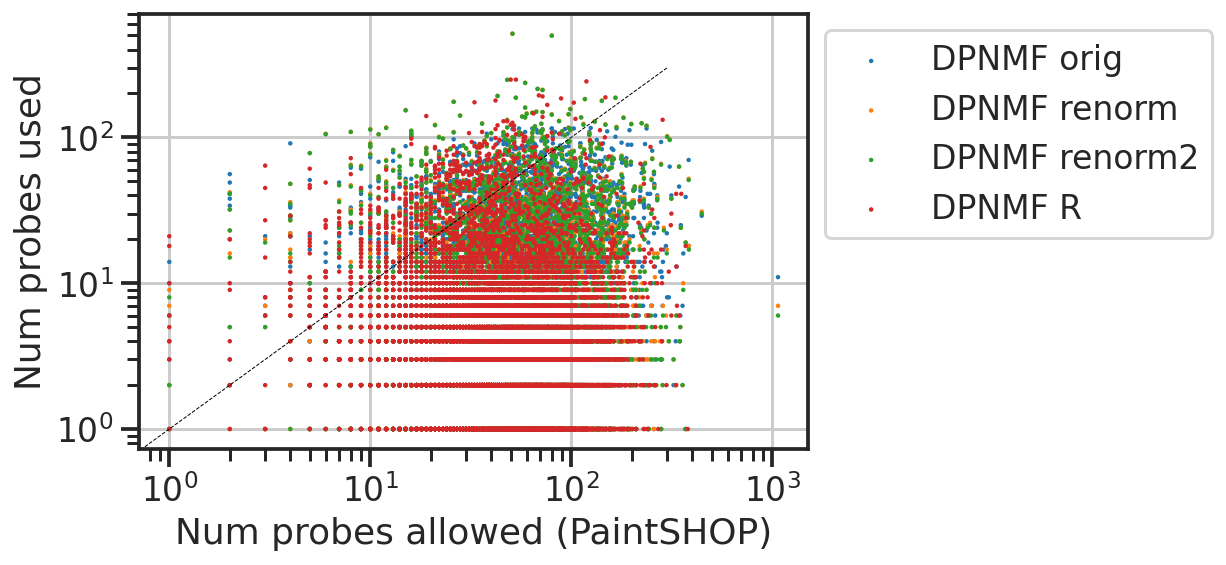

In [70]:
fig, ax = plt.subplots()
for lbl in methods:
    allowed = all_alwd[lbl]
    used = all_used[lbl]
    ax.scatter(allowed, used, s=5, label=lbl, edgecolor='none')

ax.legend(bbox_to_anchor=(1,1))
ax.plot([0,300], [0,300], '--k', linewidth=0.5)
ax.set_xlabel('Num probes allowed (PaintSHOP)')
ax.set_ylabel('Num probes used')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

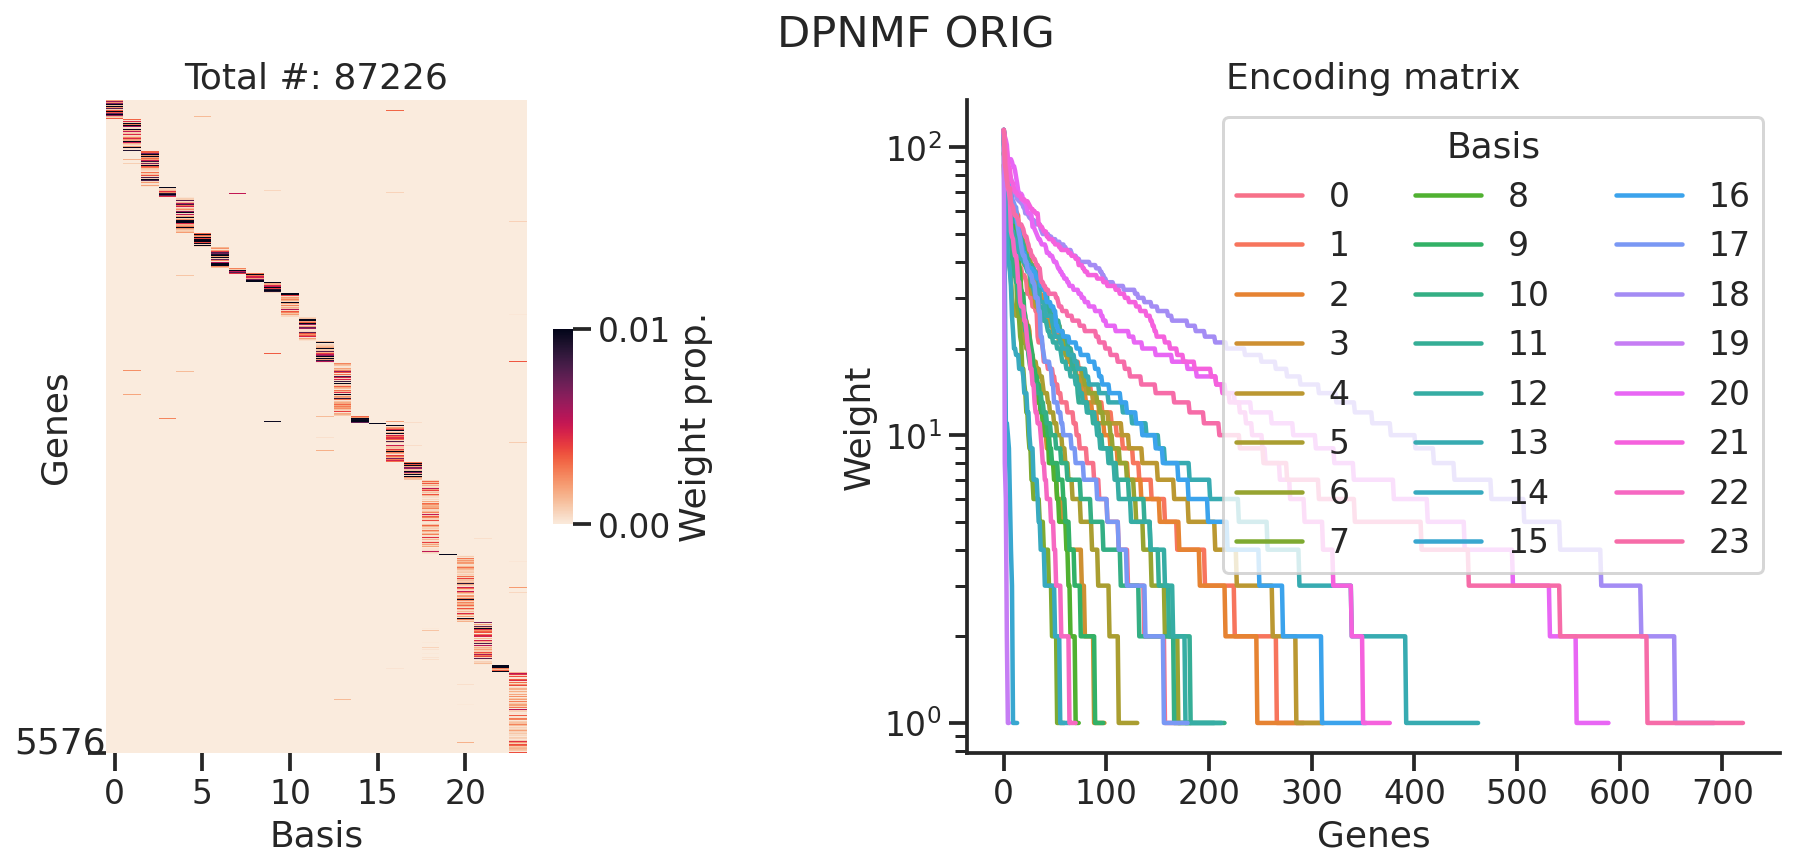

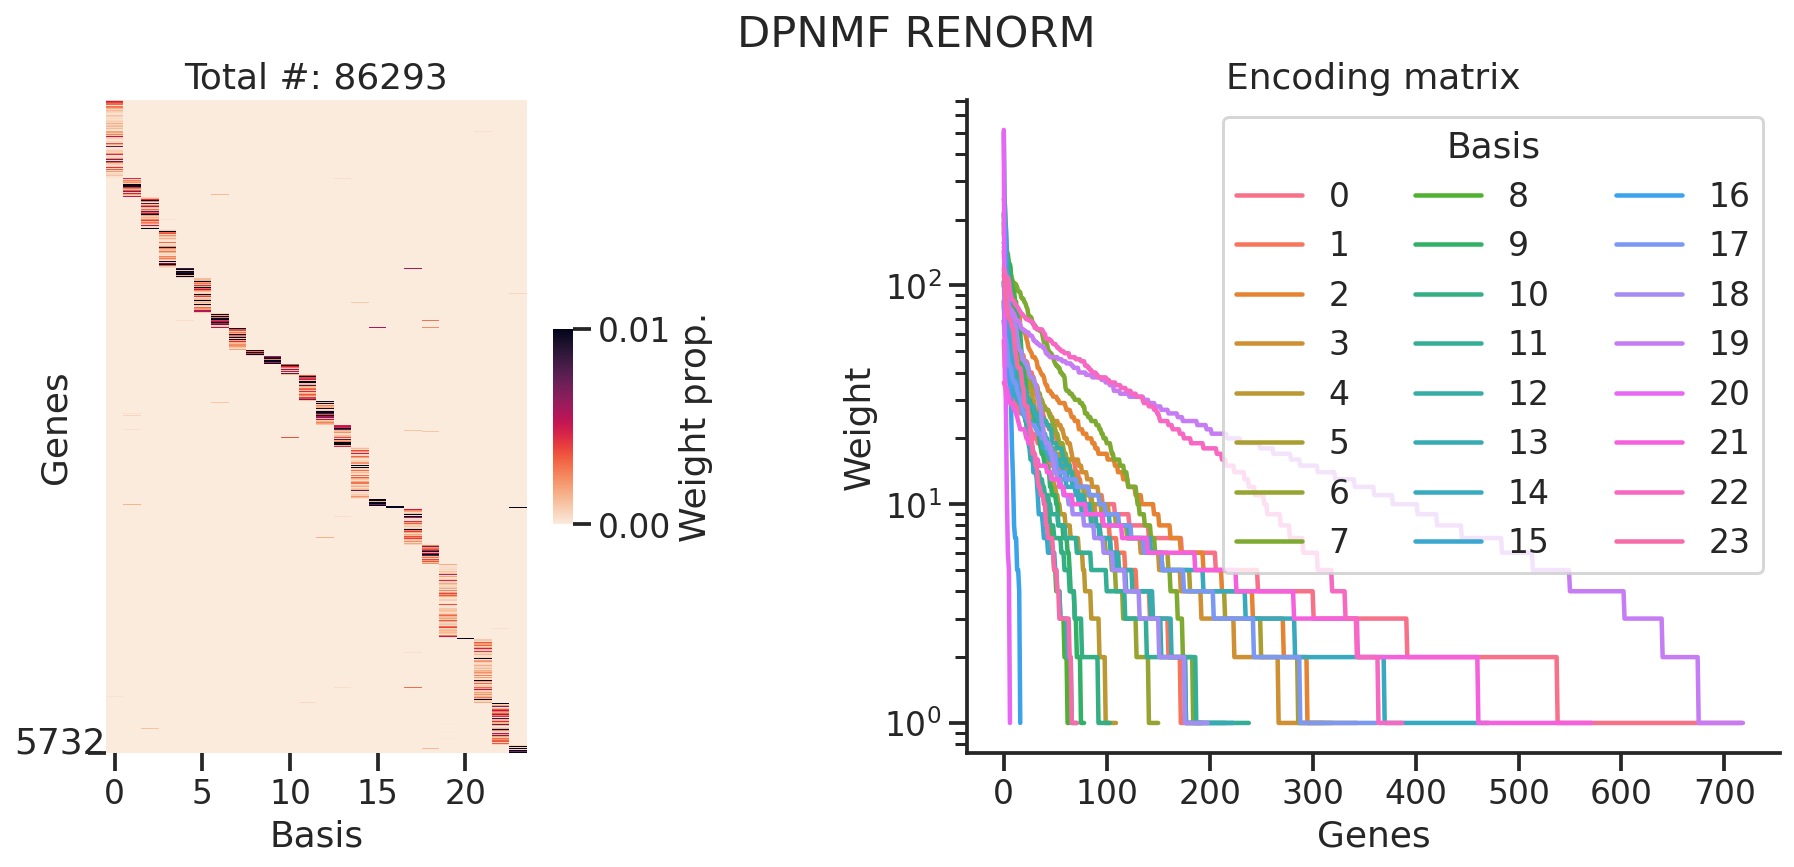

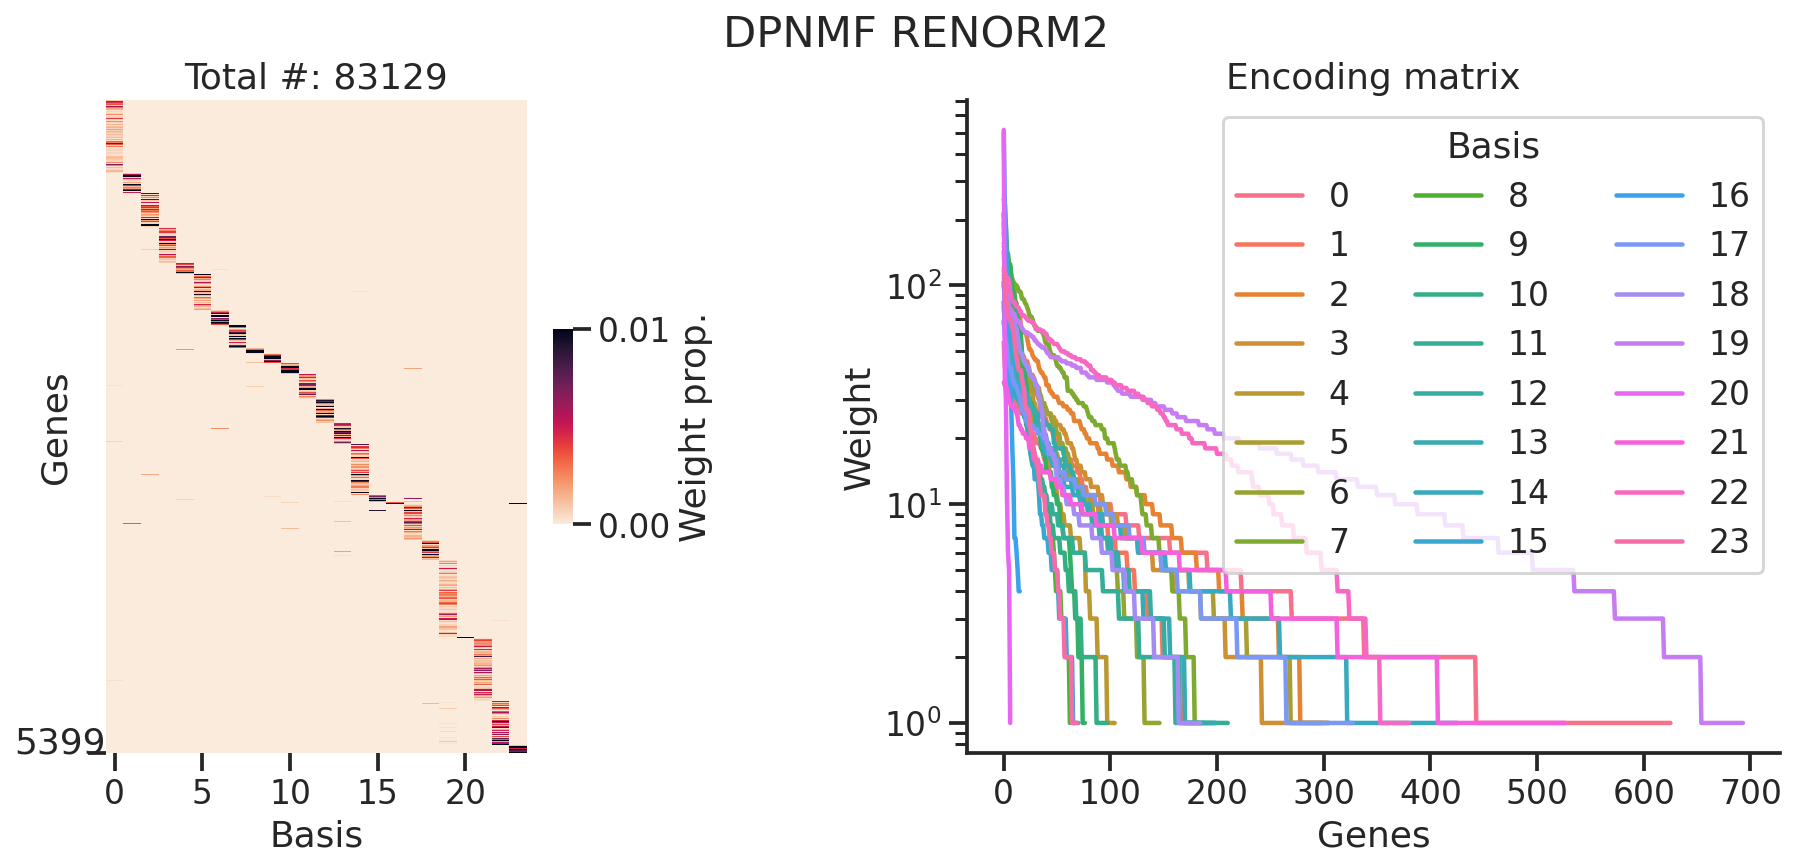

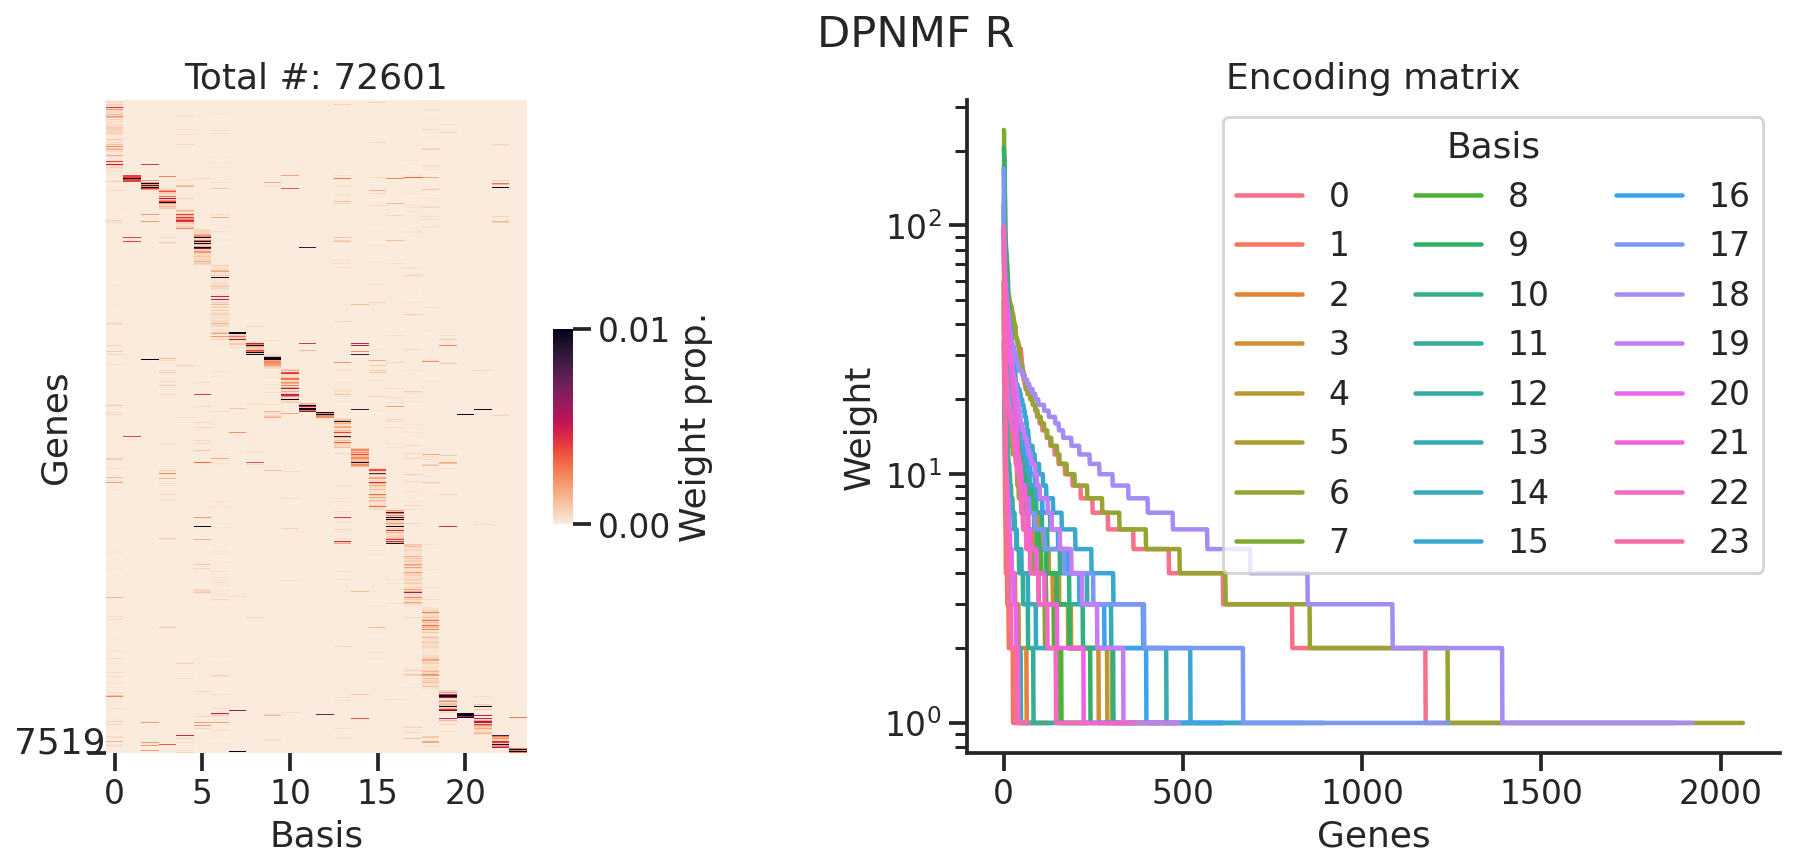

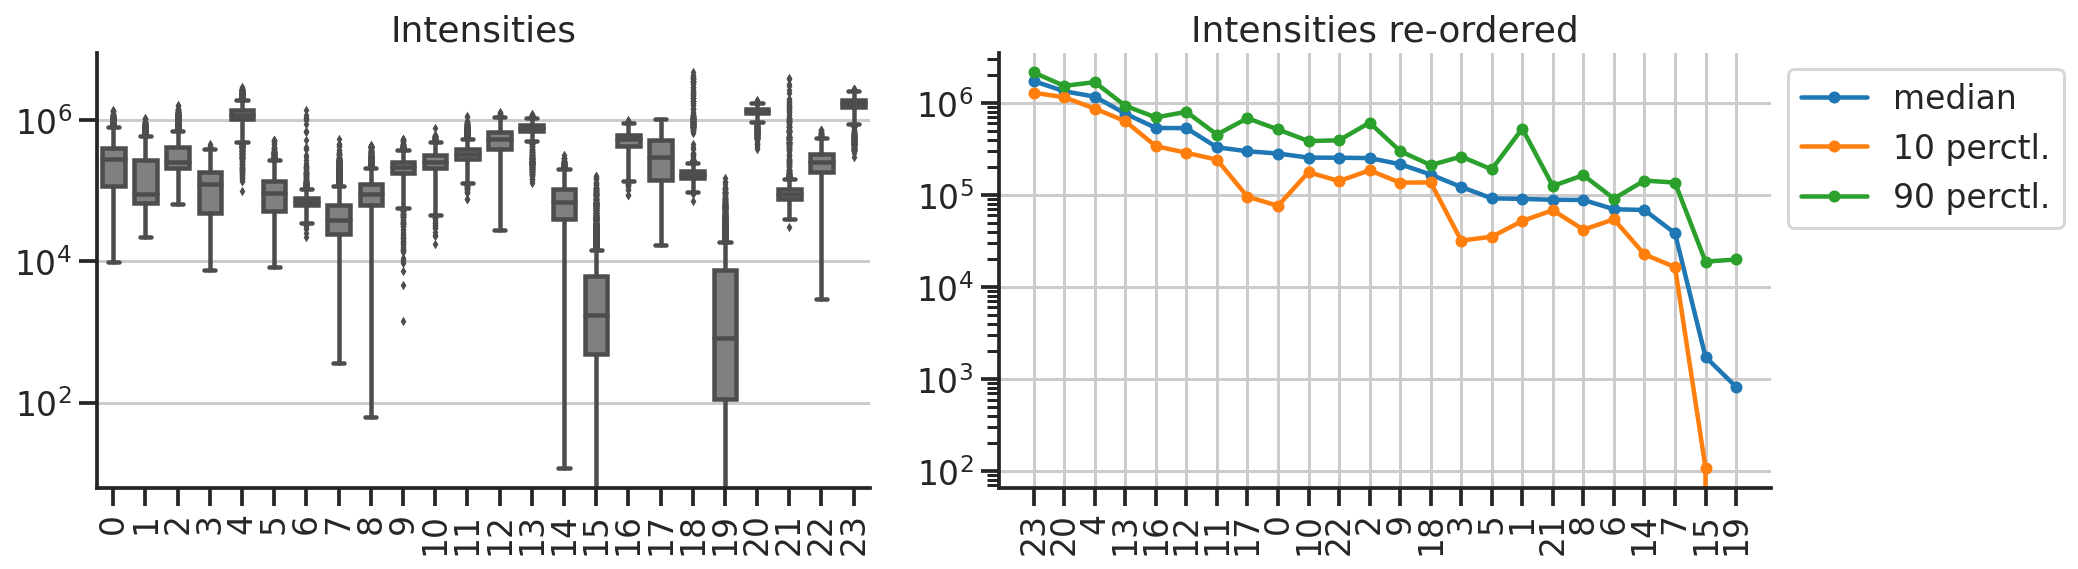

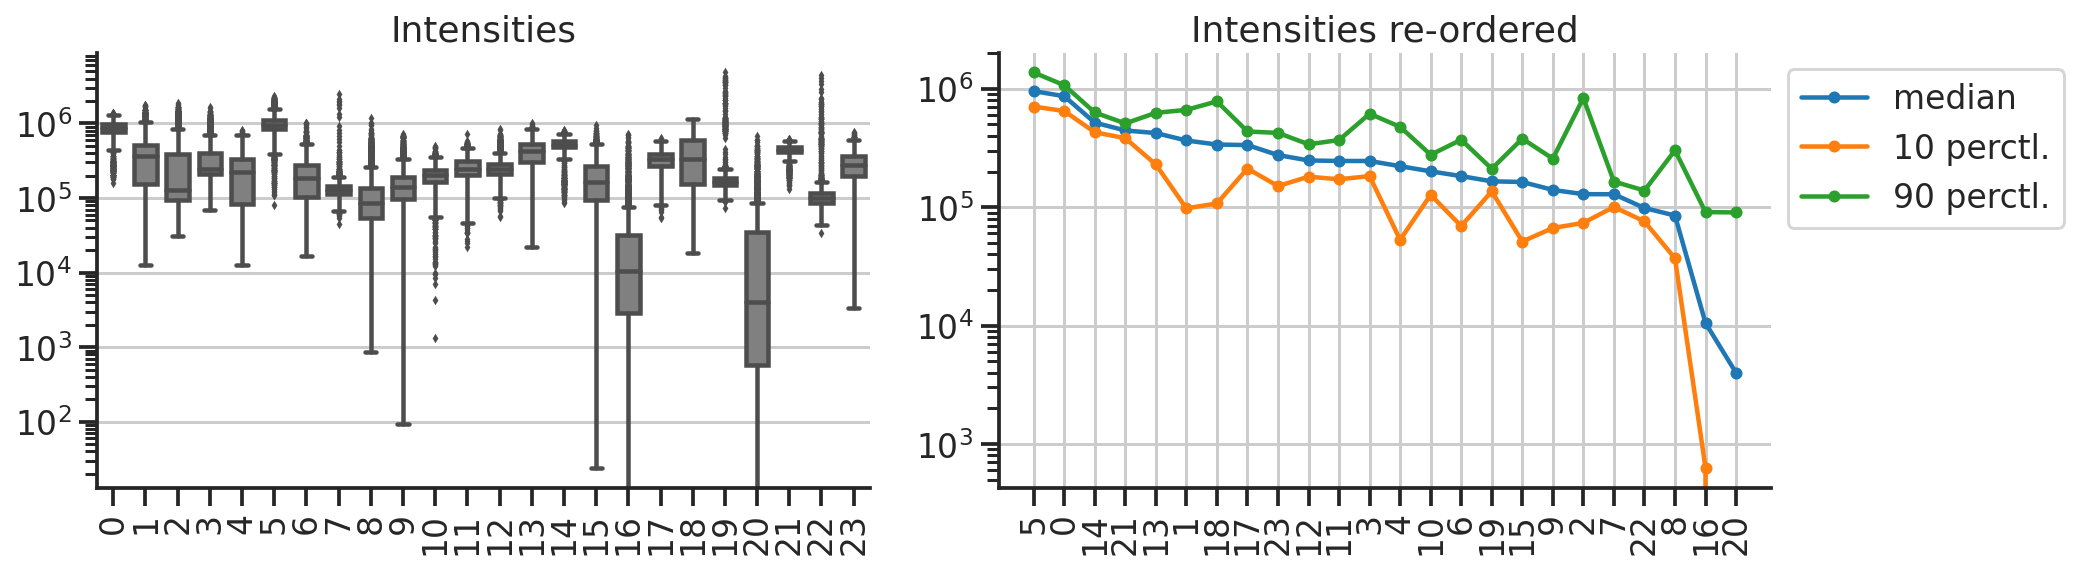

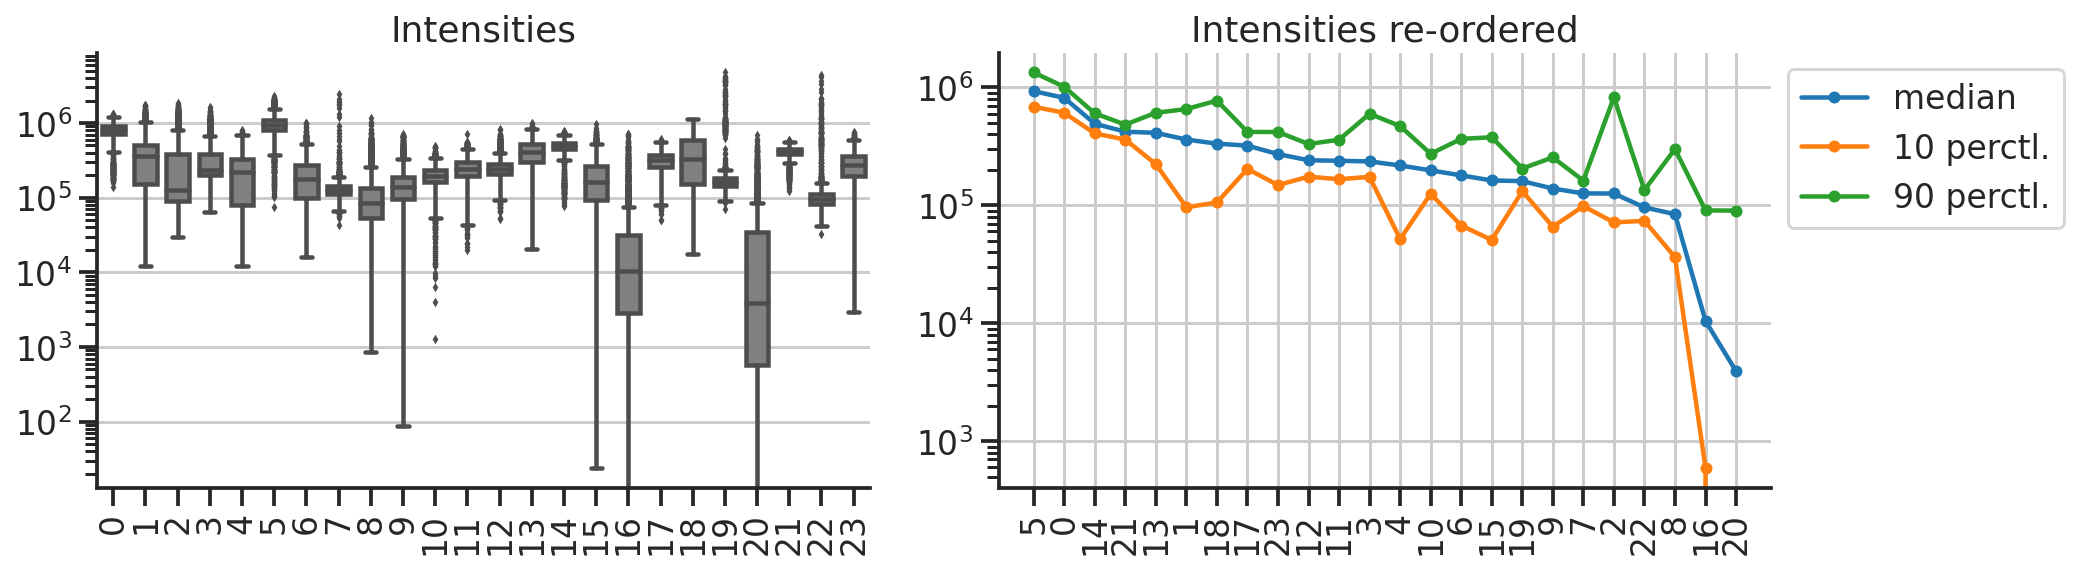

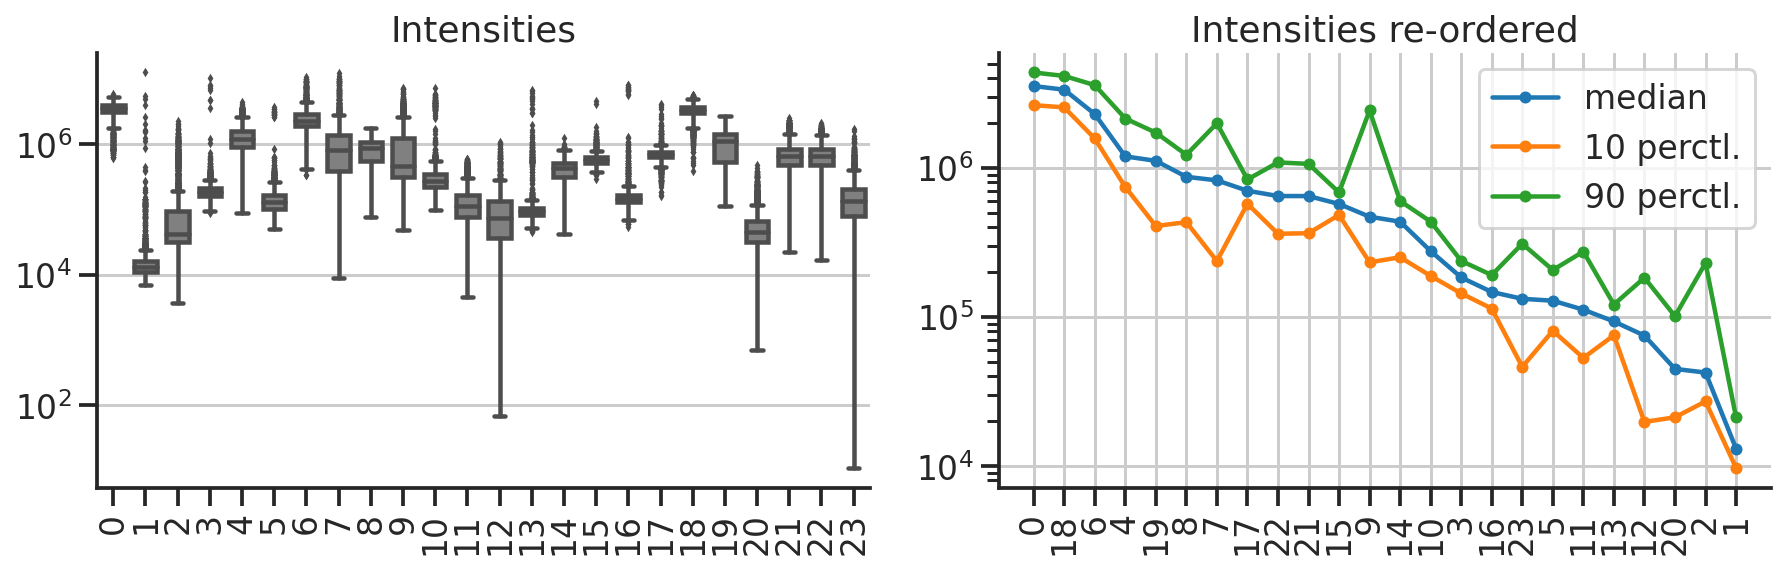

In [71]:
for meth in methods:
    pmat = all_pmats[meth]
    fpmat = all_res[meth][0]
    designu.plot_enc(pmat, fpmat, title=meth.upper())
    
for meth in methods:
    prjx = all_res[meth][1]
    designu.plot_intn(prjx)

In [72]:
colors

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098)]

DPNMF orig
DPNMF renorm


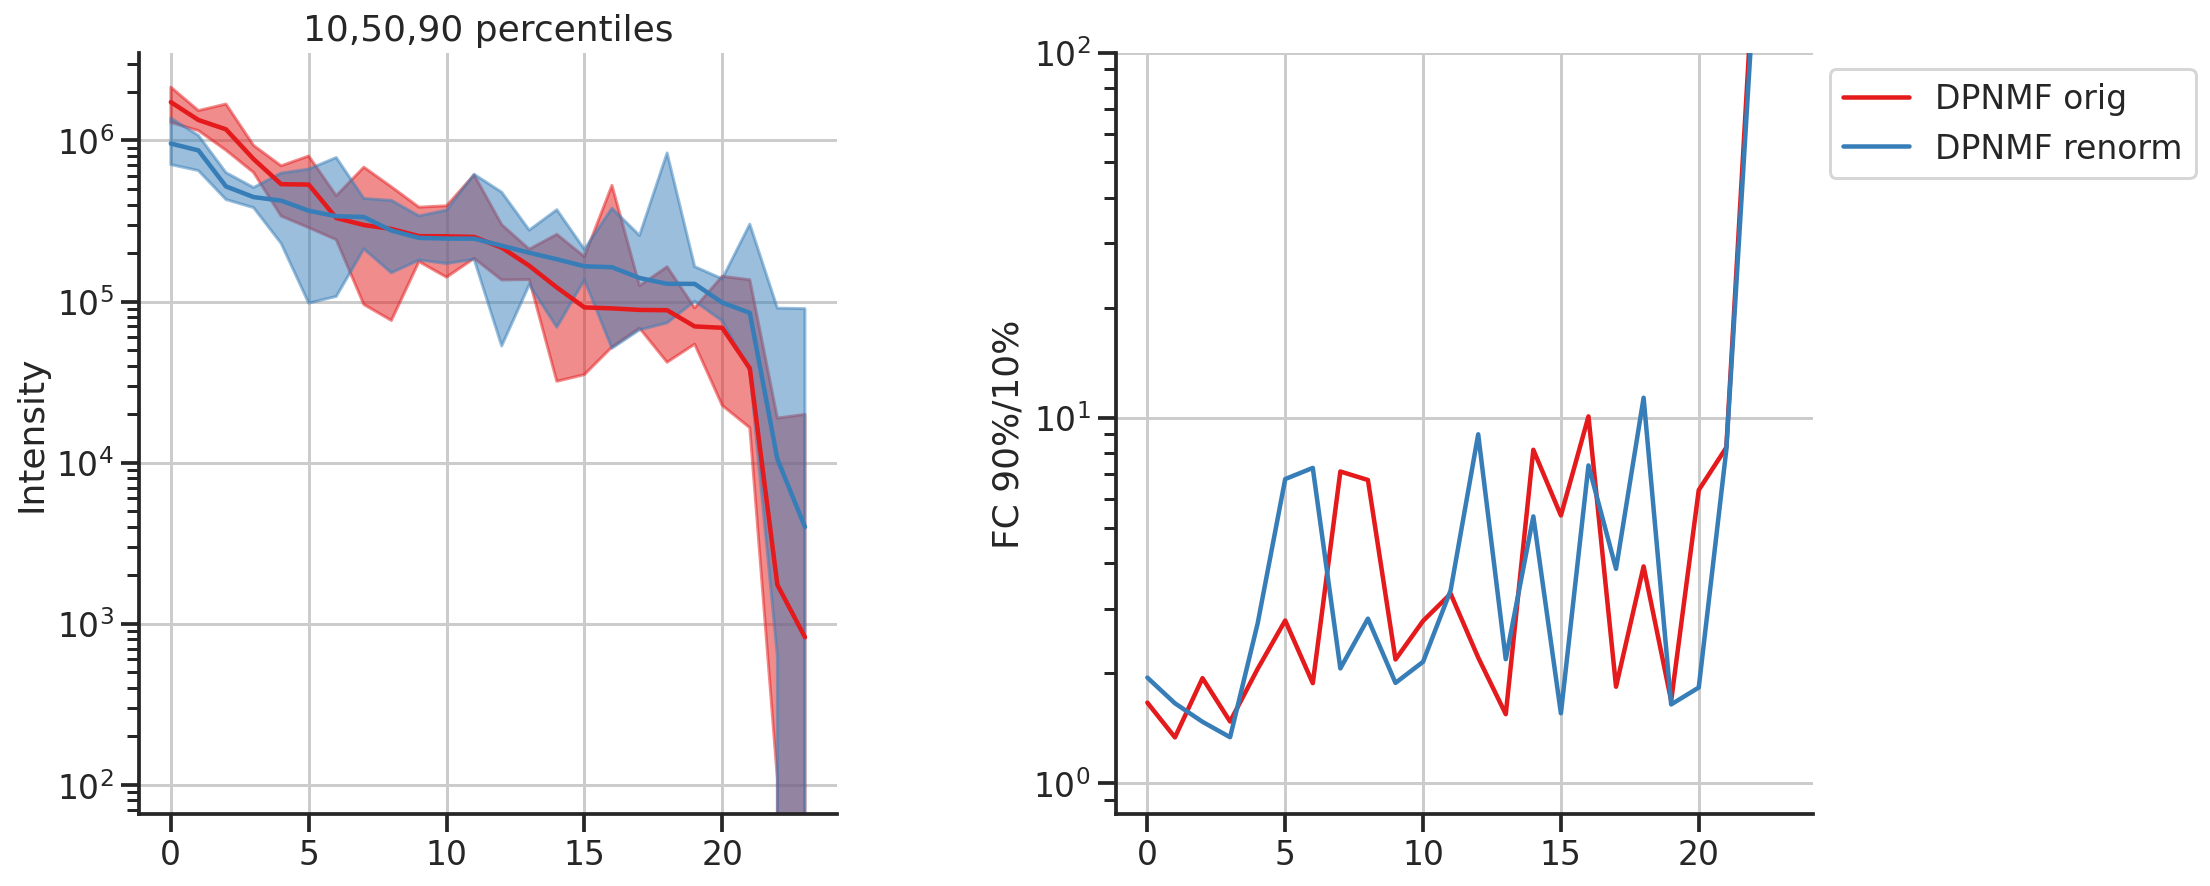

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax1, ax2 = axs
for i, meth in enumerate(methods[:2]):
    print(meth)
    prjx = all_res[meth][1]
    color = colors[i] # f"C{i}"
    plot_intn_v2(prjx, meth, color, ax1, ax2)
fig.subplots_adjust(wspace=0.4)
plt.show()

In [26]:
# # HC ordering
# for meth in methods:
#     fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols = all_res[meth] 
#     designu.plot_embx_clsts(prjx_clsts, embx_clsts_z, embx_clsts_z, 
#                             rownames=type_orders, # before rearange 
#                             colnames=np.arange(24), # before rearange
#                             _rows=_rows, # how to rearange
#                             _cols=_cols, #_dcols, #None, 
#                             title=meth,
#                             figsize=(3*6, 1*10),
#                             title2='bitwise zscored [mean(Z)]',
#                             title3='bitwise zscored [mean(Z)]',
#                            )

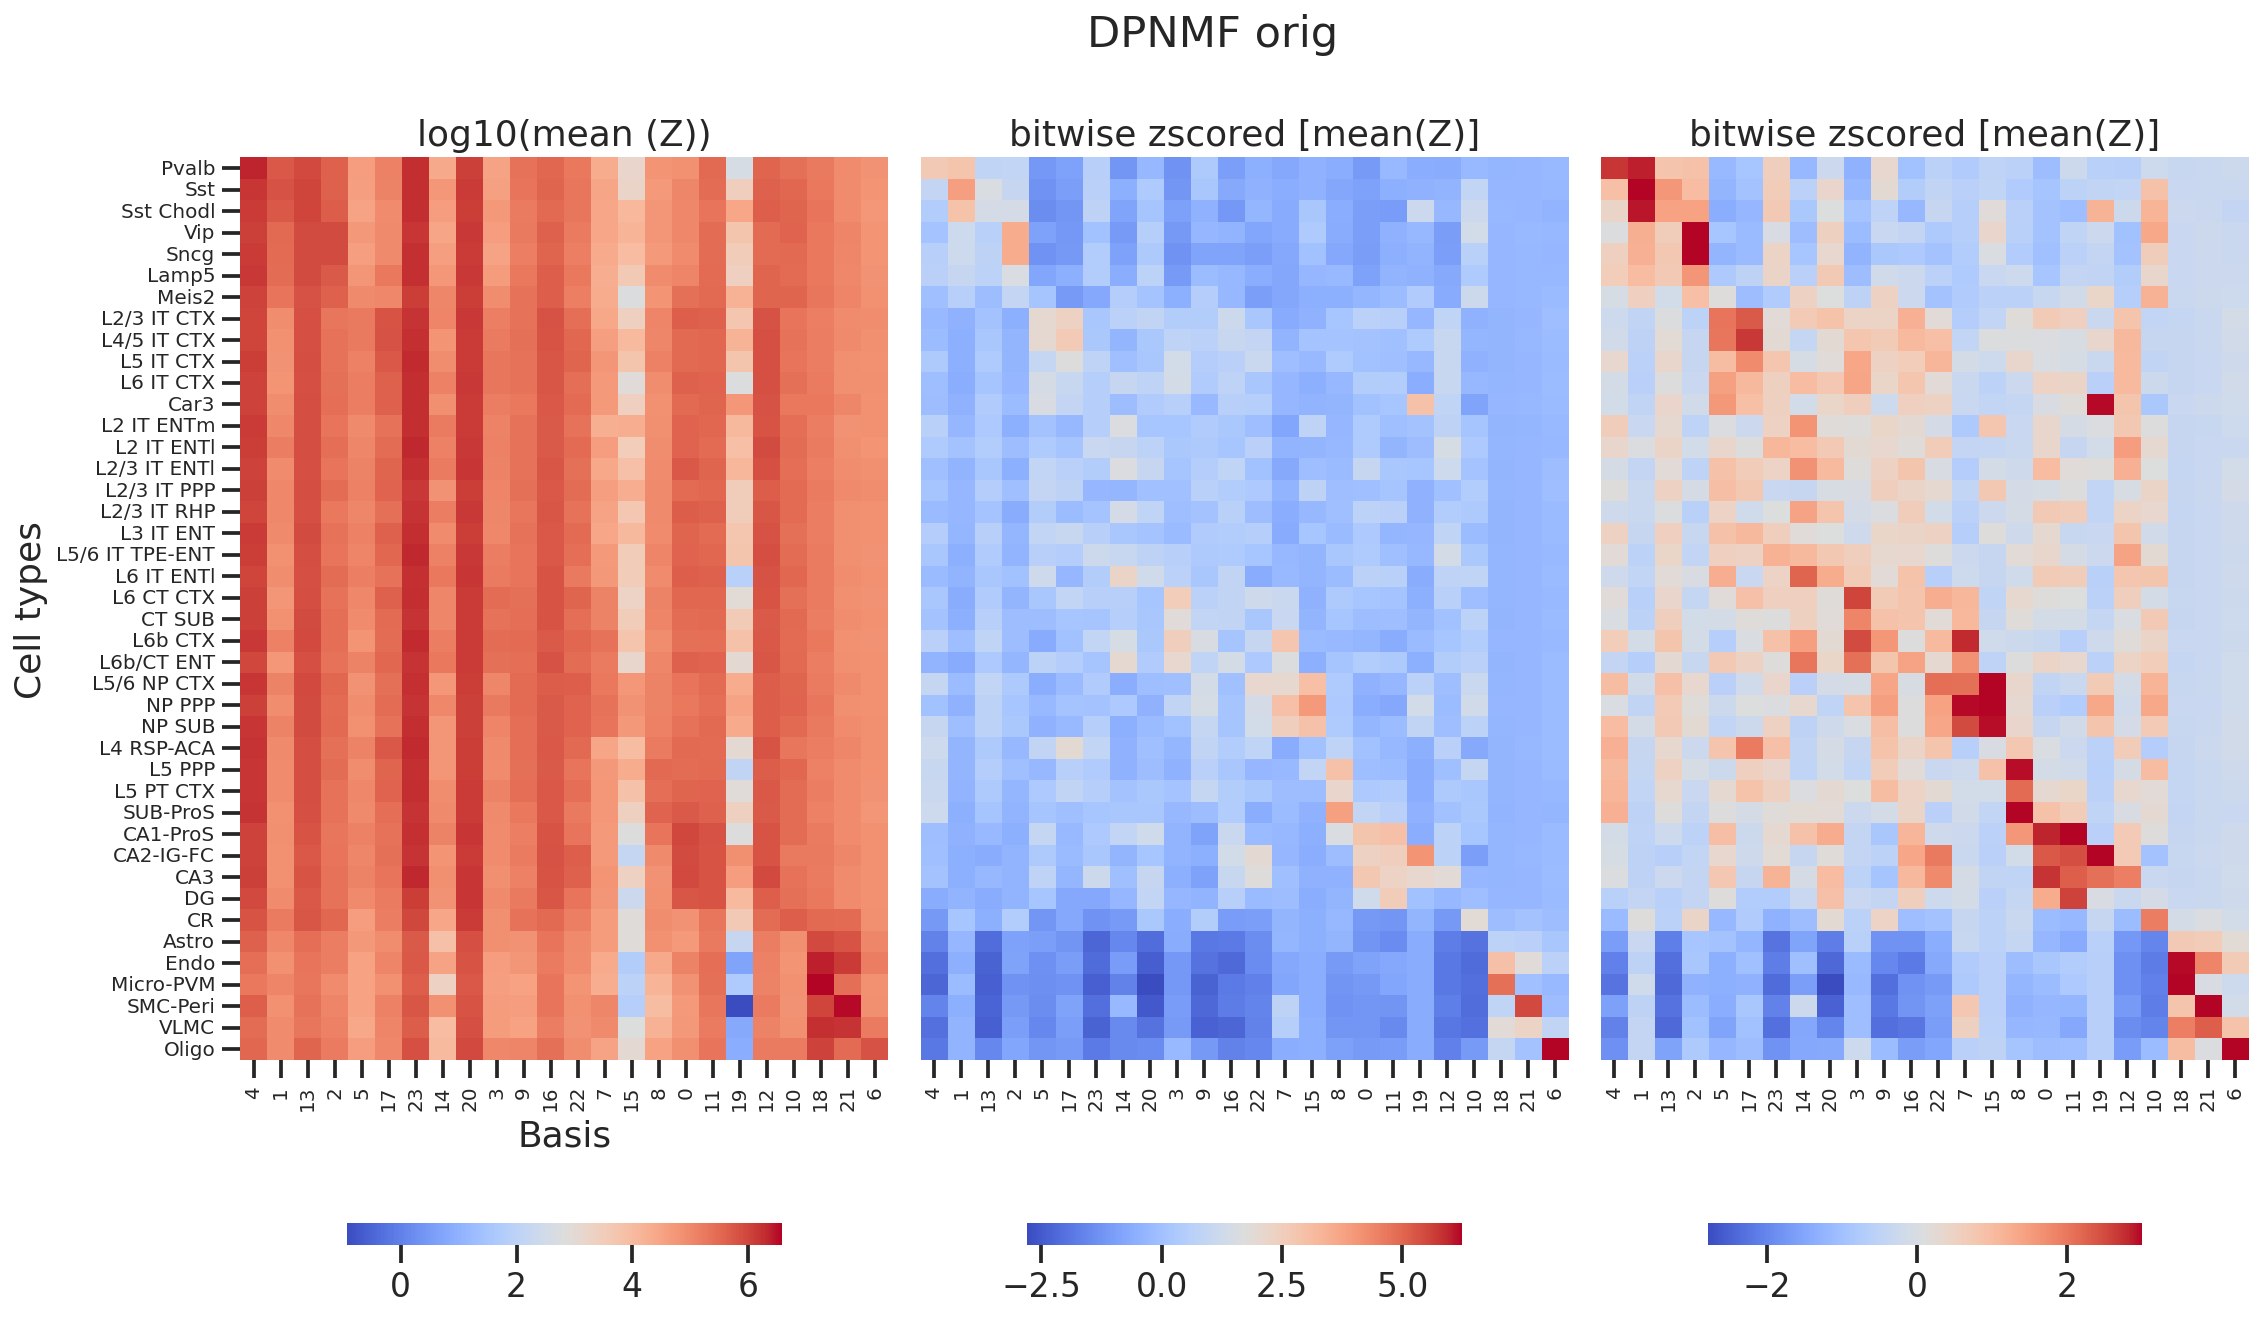

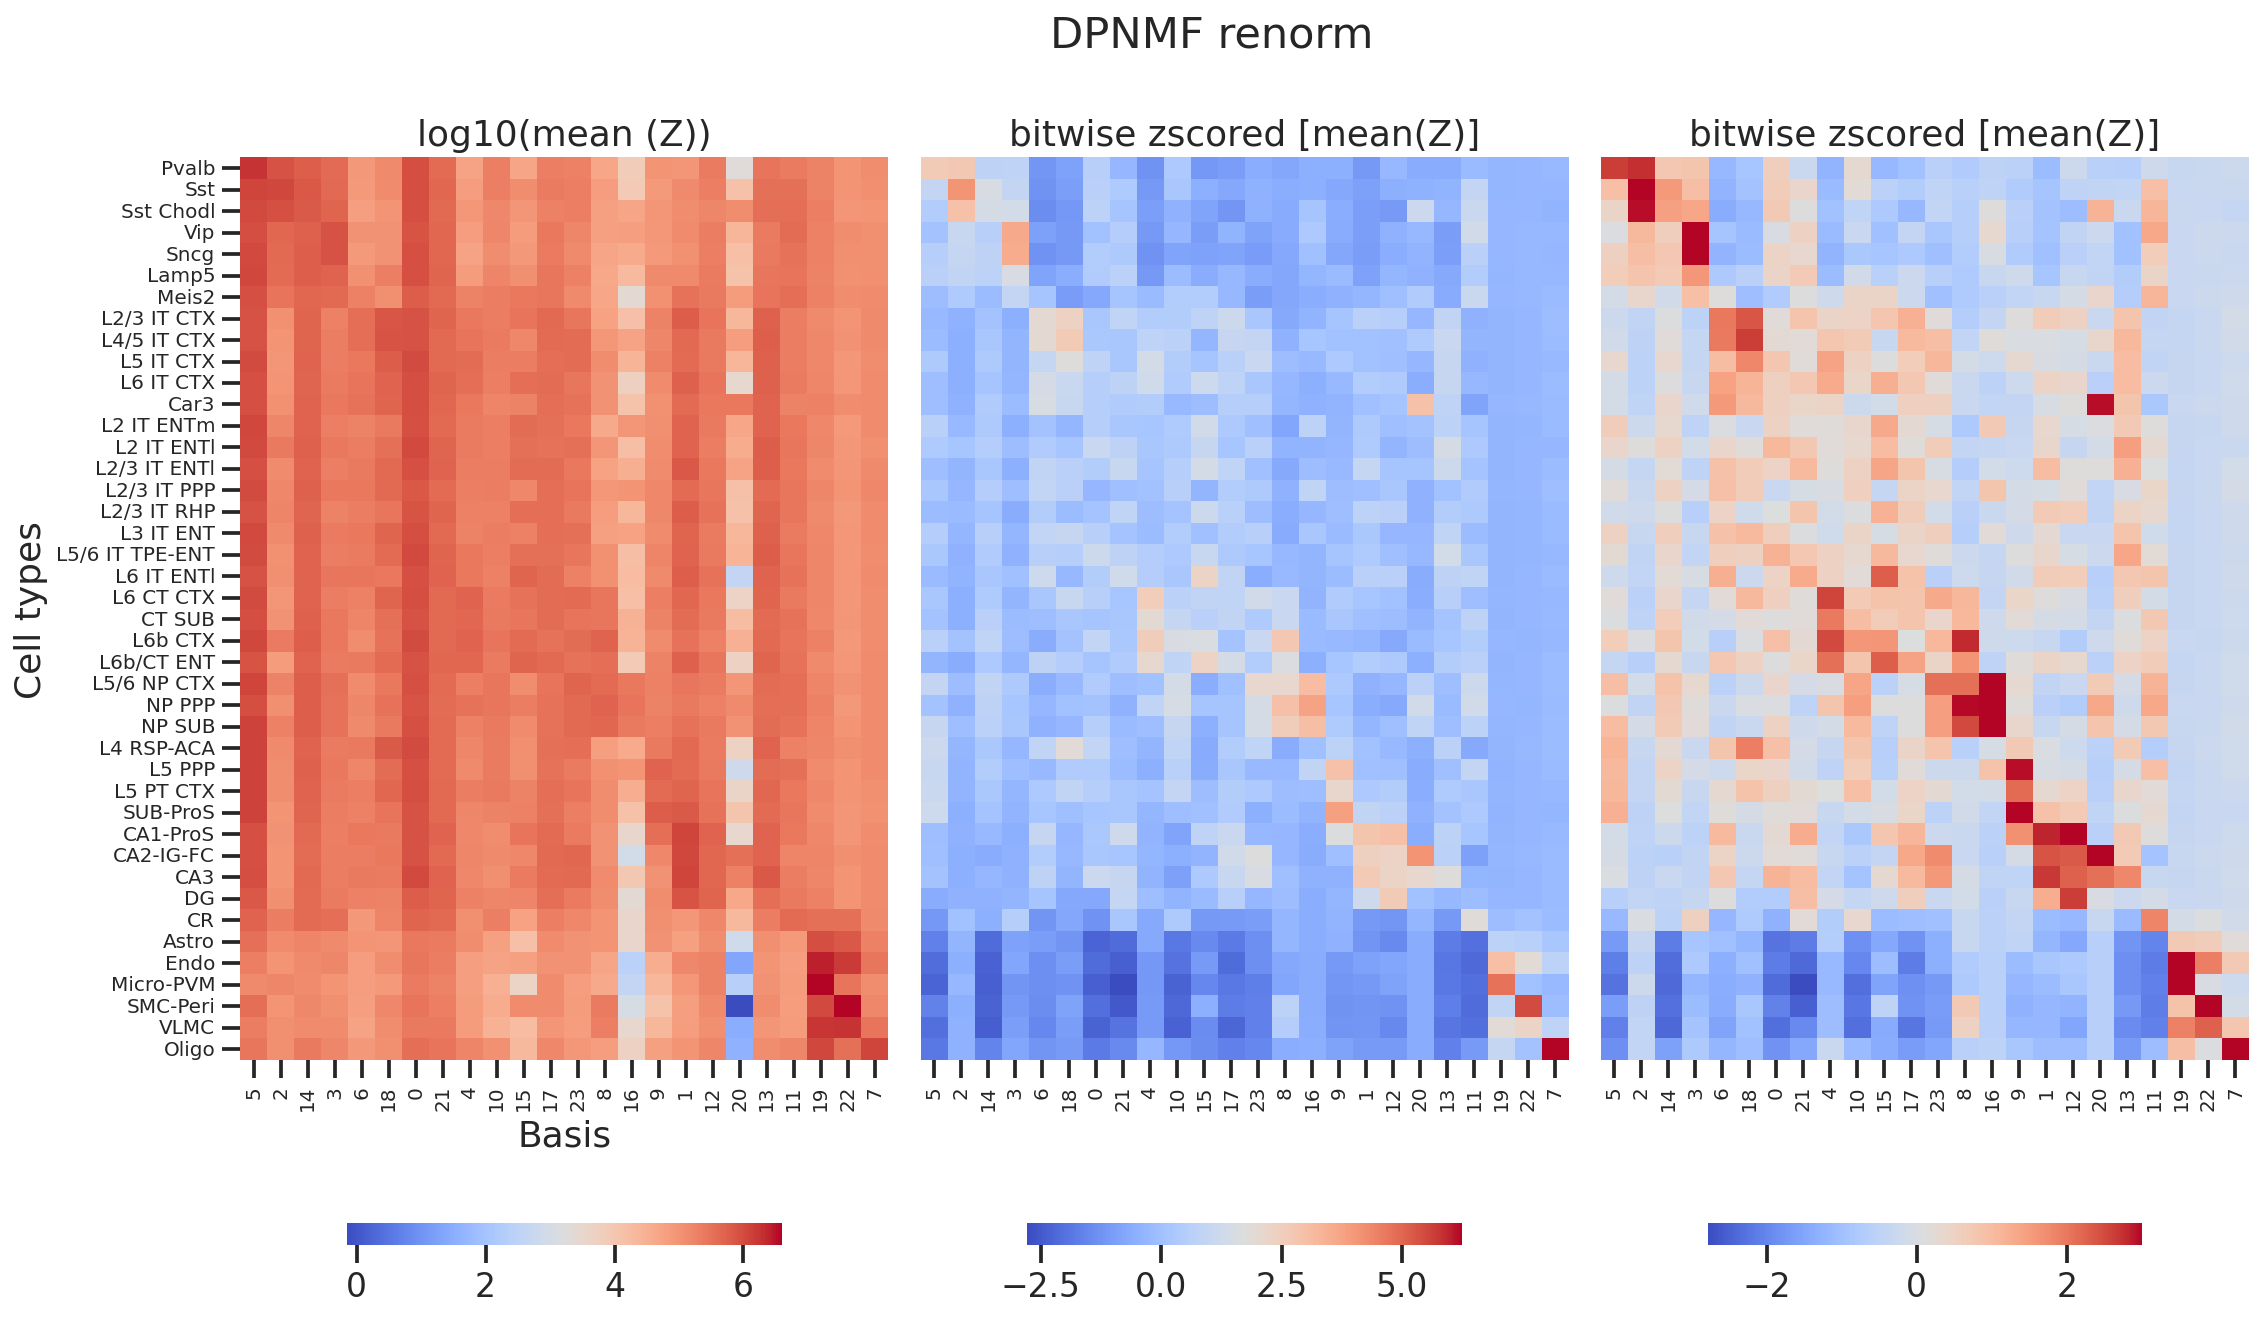

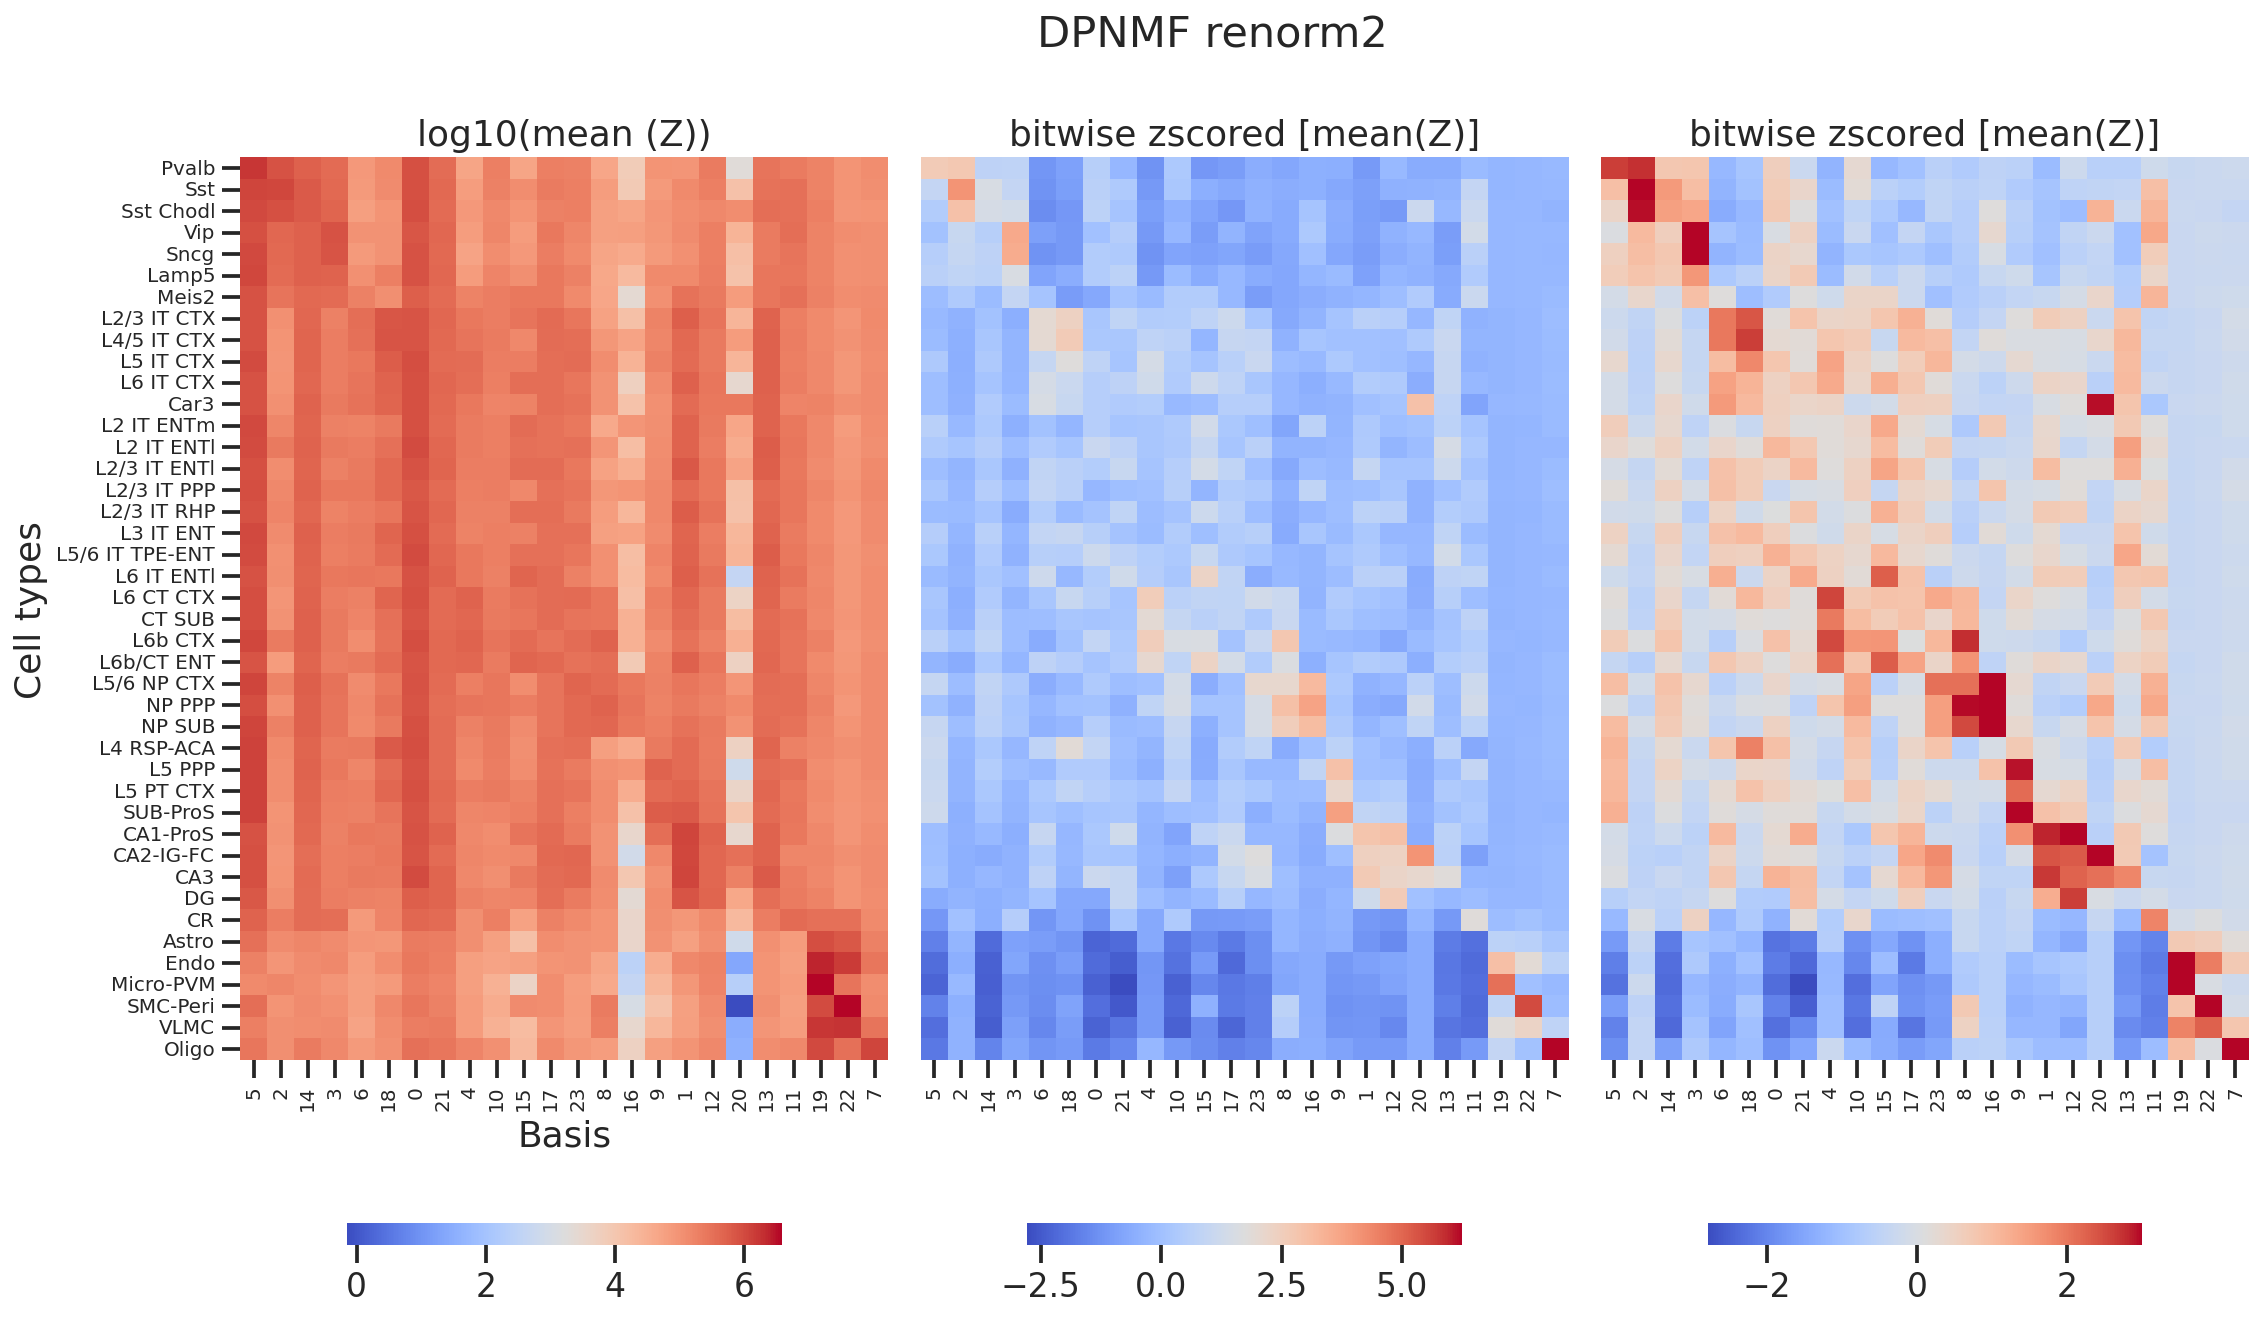

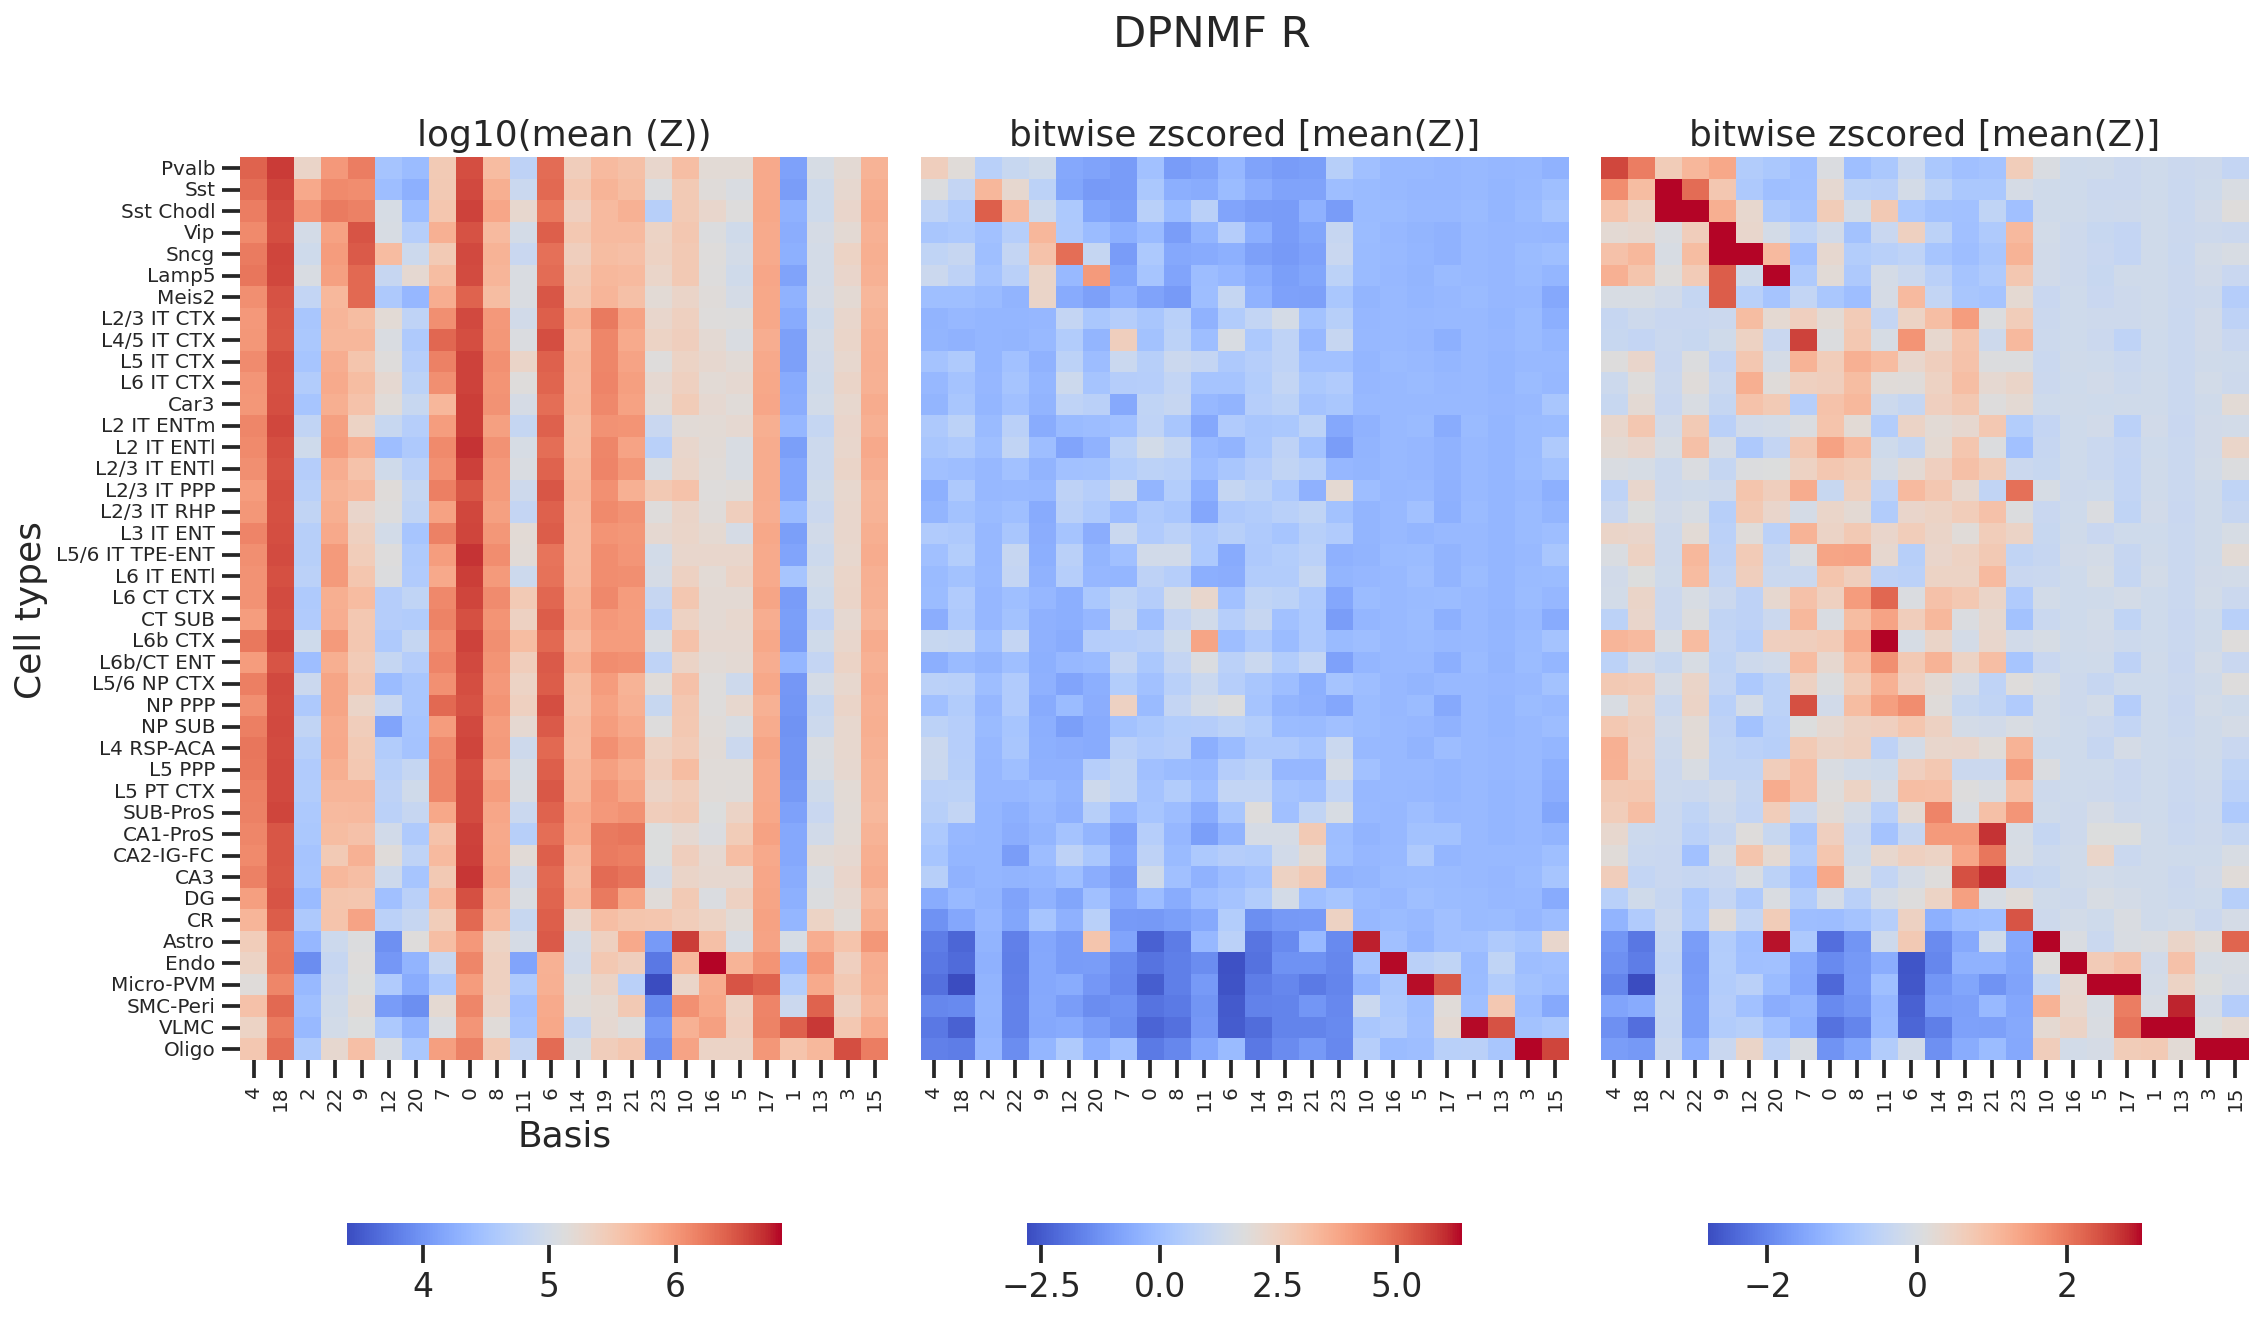

In [27]:
# diagnal ordering
for meth in methods:
    fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols, = all_res[meth] 
    designu.plot_embx_clsts(prjx_clsts, embx_clsts_z, embx_clsts_z, 
                            rownames=type_orders, # before rearange 
                            colnames=np.arange(24), # before rearange
                            _rows=_rows_l3clsts, # how to rearange
                            _cols=_dcols, #_dcols, #None, 
                            title=meth,
                            figsize=(3*6, 1*10),
                            title2='bitwise zscored [mean(Z)]',
                            title3='bitwise zscored [mean(Z)]',
                           )

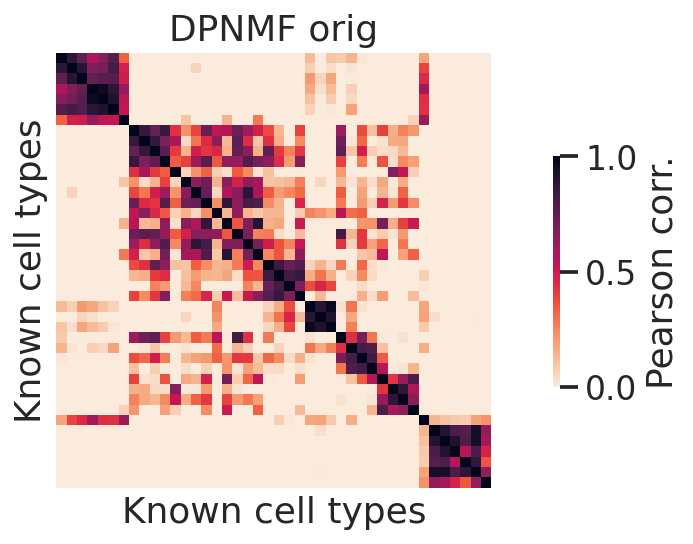

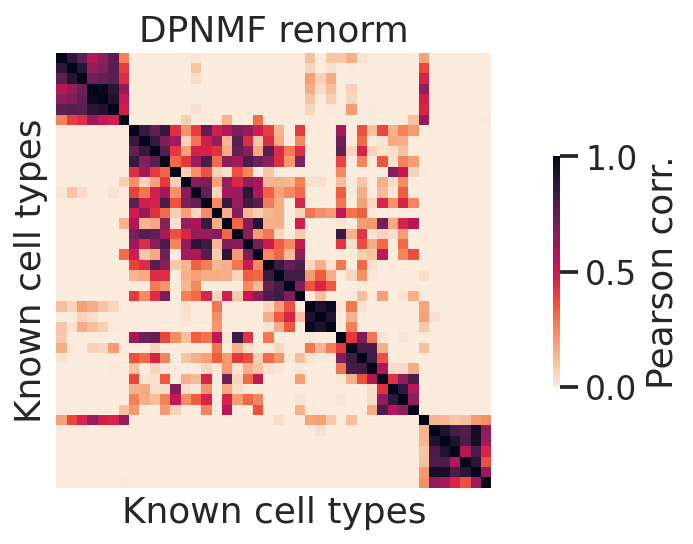

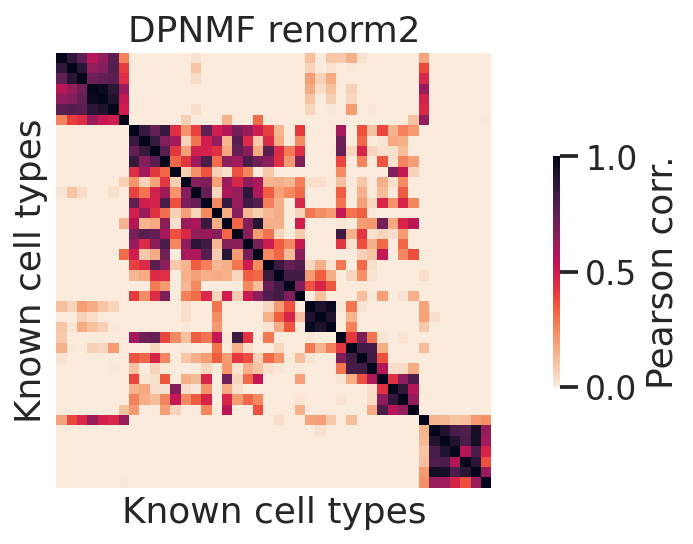

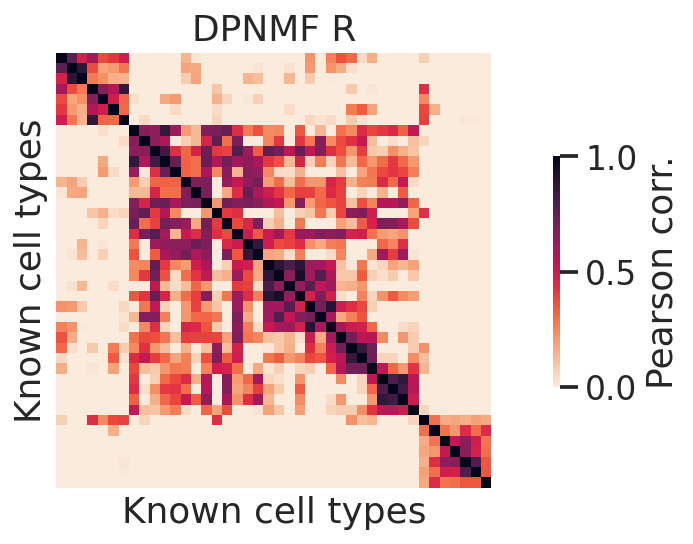

In [28]:
for meth in methods:
    fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols = all_res[meth] 
    designu.plot_heatcorr(
        # embx_clsts_corr, 
        embx_clsts_corr[_rows_l3clsts,:][:,_rows_l3clsts], 
        vmin=0, title=meth)

In [51]:
fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols1, = all_res['DPNMF orig'] 
fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols2, = all_res['DPNMF renorm'] 

In [52]:
a, b = all_pmats['DPNMF orig'].values, all_pmats['DPNMF renorm'].values
a.shape, b.shape

((9174, 24), (9174, 24))

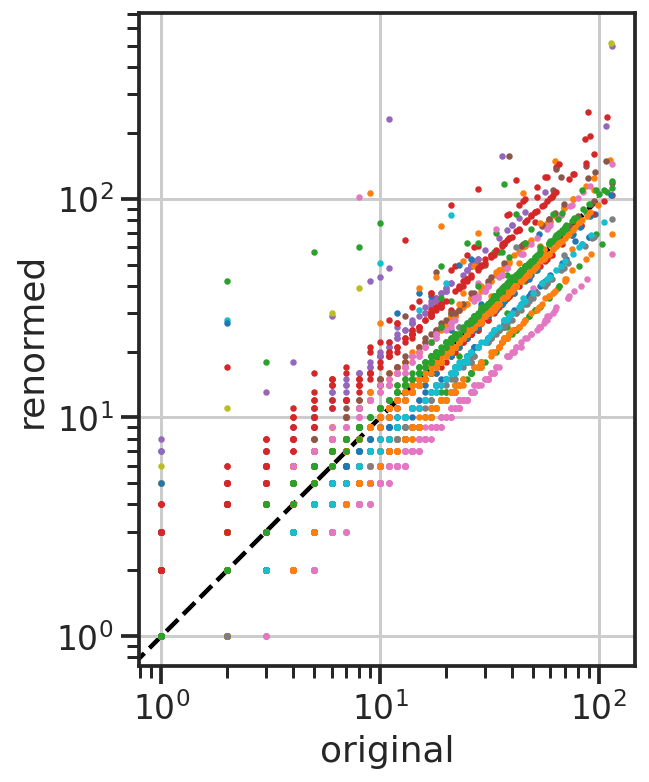

In [53]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([0,100],[0,100], '--k', zorder=0)
for col1, col2 in zip(_dcols1, _dcols2):
    ax.scatter(a[:,col1], b[:,col2],s=3)
ax.set_xlabel('original')
ax.set_ylabel('renormed')
ax.set_aspect('equal')
ax.set_xscale('log')
ax.set_yscale('log')


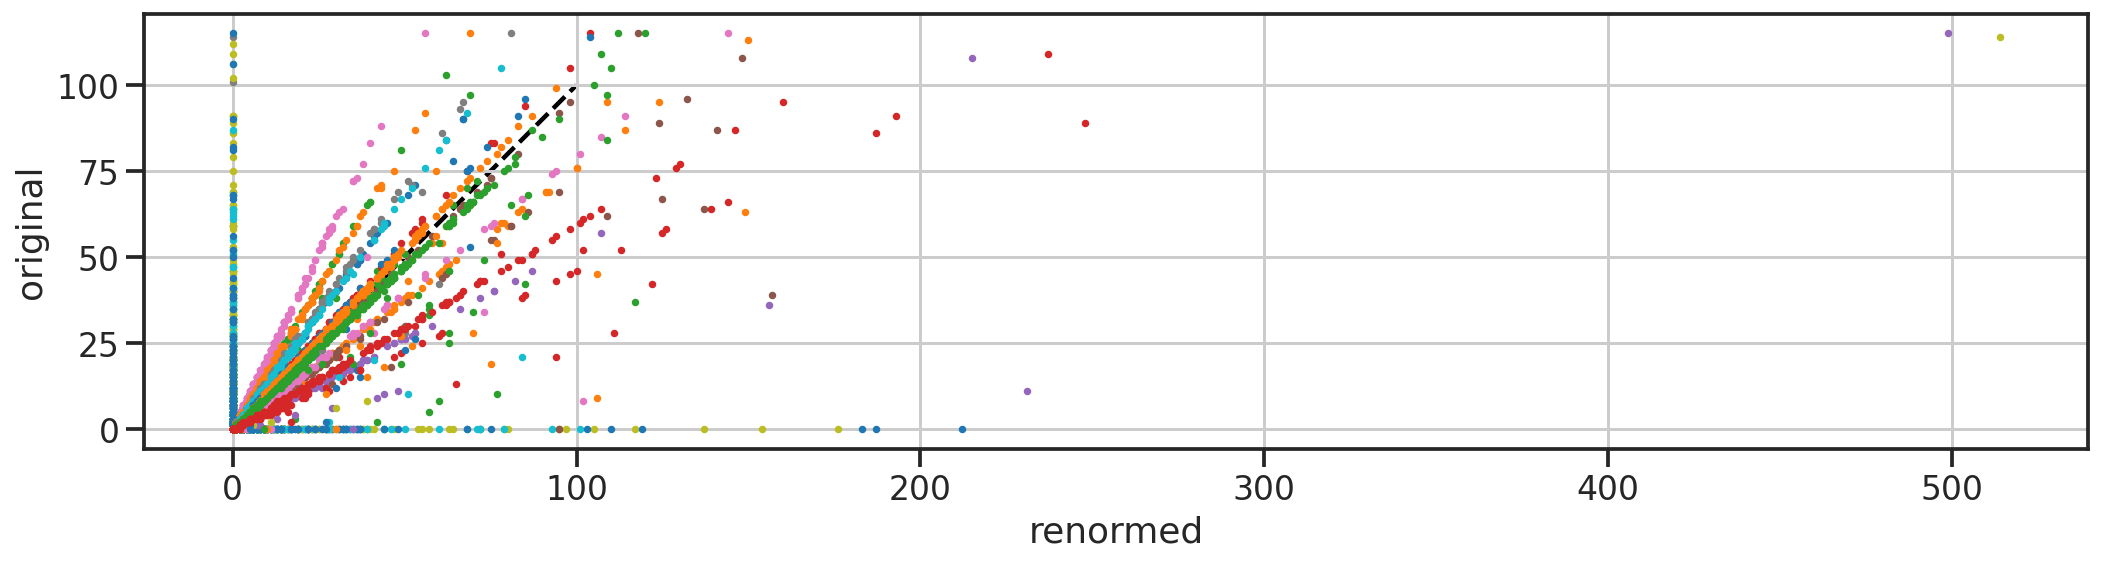

In [54]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot([0,100],[0,100], '--k', zorder=0)
for col1, col2 in zip(_dcols1, _dcols2):
    x, y = b[:,col2], a[:,col1]
    ax.scatter(x, y, s=5)
    
    # ax.plot(x[np.argsort(x)],
    #         y[np.argsort(x)],
    #        )
    
ax.set_xlabel('renormed')
ax.set_ylabel('original')
ax.set_aspect('equal')

# ax.set_xscale('log')
# ax.set_yscale('log')

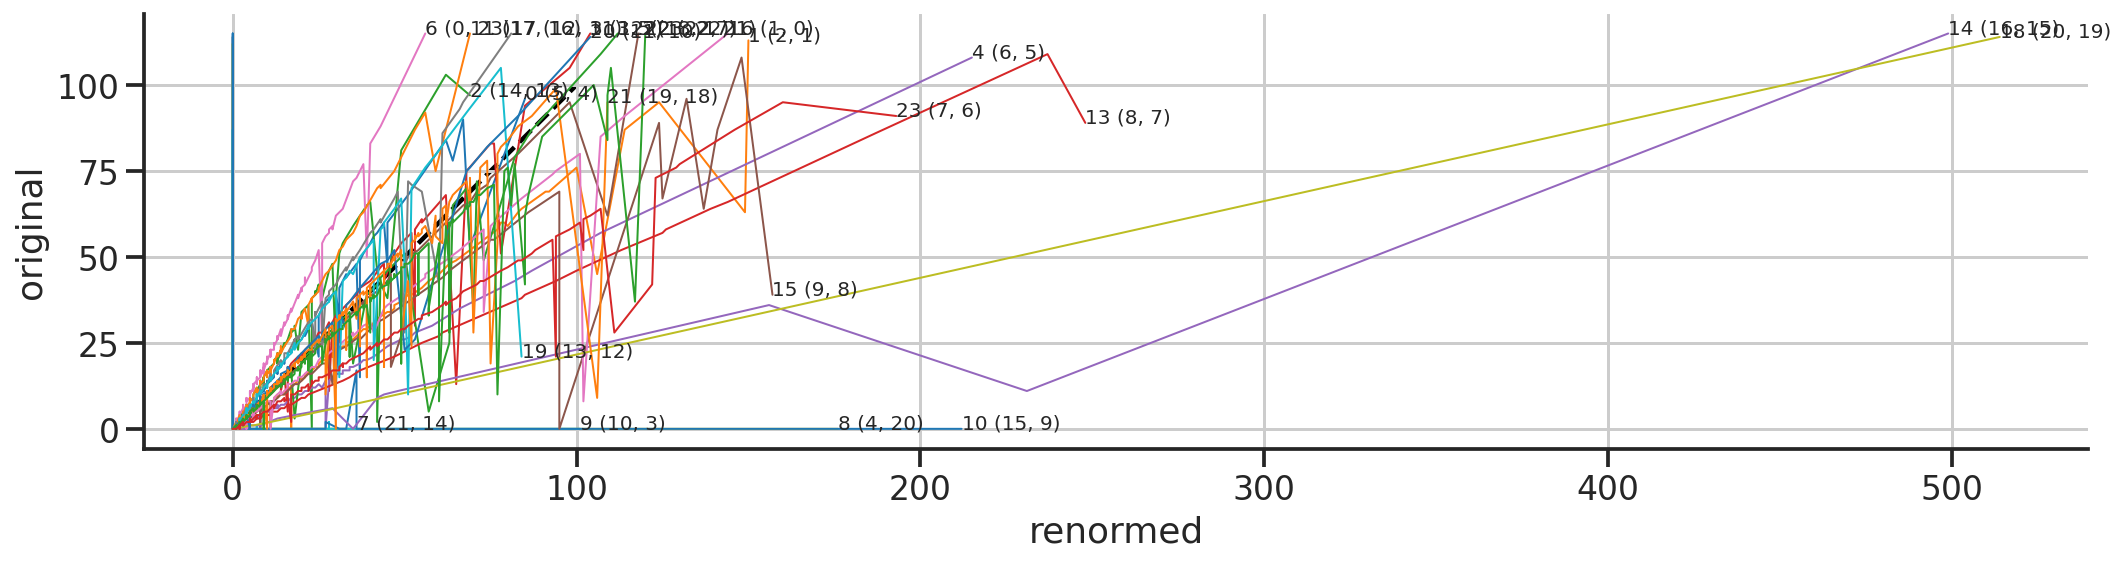

In [57]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot([0,100],[0,100], '--k', zorder=0)
for i, (col1, col2) in enumerate(zip(_dcols1, _dcols2)):
    x, y = b[:,col2], a[:,col1]
    # ax.scatter(x, y, s=5)
    
    x, y = x[np.argsort(x)], y[np.argsort(x)]
    ax.plot(x, y, linewidth=1,)
    ax.text(x[-1], y[-1], f"{i} ({col2}, {col1})", fontsize=10)
ax.set_xlabel('renormed')
ax.set_ylabel('original')
ax.set_aspect('equal')
sns.despine(ax=ax)

# ax.set_xscale('log')
# ax.set_yscale('log')

In [61]:
a[:,_dcols1][:,[14,18]]

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [62]:
b[:,_dcols2][:,[14,18]]

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [63]:
a[:,_dcols1][:,[14,18]].sum(axis=0)

array([210, 132])

In [64]:
b[:,_dcols2][:,[14,18]].sum(axis=0)

array([1152,  606])